<a href="https://colab.research.google.com/github/fshnkarimi/Labeling/blob/main/Buy%26Hold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import glob
from dateutil import parser

# Read dataframes
path = r'/content' 
all_files = glob.glob(path + "/*.csv")

df_dict = {}

for filename in all_files:
    key = filename.split('/')[len(filename.split('/')) -1 ].split('.')[0]
    df = pd.read_csv(filename, index_col=None, header=0)
    df_dict[key] = df


In [ ]:
# Implement Buy&Hold strategy
def buy_and_sell(df, InitialCapital):
    '''
    Update capital and number of shares after each buy or sell based on labels.

    Parameters
    ----------
        df : dataframe
            target dataframe for using buh&hold strategy
        InitialCapital : int
            Amount of initial capital
        
    Returns
    -------
    dataframe
        modified dataframe after implementing buy&hold strategy on input dataframe
    """
    '''
    capital = InitialCapital
    stock = 0
    old_trend = new_trend = df.Label[0]
    final_capitals = []
    last_index = df.loc[df.Label == 0, :].tail(1).index
    for i in range(df.Label.count()):
        new_trend = df.Label[i]
        
        if new_trend == 1 and capital != 0 and df.index[i] <= last_index:
          # Buy
          stock = capital / df.Price[i]
          capital = 0
          df['Trade Signal'][i] = 'Buy'
          df['Number of Shares'][i] = "{0:0.2f}".format(stock)

        elif new_trend != old_trend and new_trend == 0:
            # sell
            if stock != 0:
                capital = stock * df.Price[i]
                stock = 0
                df['Trade Signal'][i] = 'Sell'
                df['Number of Shares'][i] = '0'
        else:
            if i != 0:
                df['Number of Shares'][i] = df['Number of Shares'][i-1] 

        if capital != 0:
            final_capitals.append(capital)
        else:
            final_capitals.append(stock * df.Price[i])

        old_trend = df.Label[i]
    
    df = df.assign(FinalCapital=pd.Series(final_capitals))
    return df

In [ ]:
# Calculate rate of return
def ROR(df, InitialCapital):
    '''
    Calculate rate of return for each row that we have stock

    Parameters
    ----------
        df : dataframe
            dataframe for calculating ror
        InitialCapital : int
            Amount of initial capital
        
    Returns
    -------
    dataframe
        modified dataframe after updating ROR values
    """
    '''

    df = df.assign(ROR=pd.Series(df.FinalCapital - InitialCapital)/ InitialCapital * 100)

    return df

In [ ]:
def DD(df):
    pct = df[["Price"]].pct_change()
    wealth_index = InitialCapital * (1 + pct["Price"]).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdown = (wealth_index - previous_peaks) / previous_peaks
    drawdown = list(abs(drawdown))
    drawdown[0] = 0
    df = df.assign(DD=pd.Series(drawdown))
    return df

In [ ]:
# Sharpe Ratio
# This should be changed
def sharpe_ratio(df):
    R = df.ROR[-1:].values[0]
    sr = R / df.ROR.std()
    return sr

In [ ]:
def metrics(df, InitialCapital):
    df = buy_and_sell(df, InitialCapital)
    df = ROR(df, InitialCapital)
    df = DD(df)
    MDD = max(abs(df.DD))
    # Add RRR column
    df['RRR'] = (df['ROR'] / MDD) * 100

    sr = sharpe_ratio(df)
    print(f"Sharpe Ratio = {sr} \n")
    print(f"MDD = {MDD} \n")
    return df

In [ ]:
InitialCapital = 10e6
InitialCapital

10000000.0

In [ ]:
# This function will be added to the main code

# def modify_df(df, dataset_type):
#     date_col = 'DATE'
#     close_col = 'closingprice'
#     if dataset_type == 'crypto':
#         date_col = 'Date'
#         close_col = 'Price'
#     data = {'Date': df[date_col], 'Price': df[close_col],
#         'Label': df['labels'], 'Trade Signal': '', 'Number of Shares': '0'}
#     df_new = pd.DataFrame(data)
#     return df_new

In [ ]:
# This function will be uncomment after updating the main code

# def add_metrics(df, file_name):
#     metrics_ = metrics(df, InitialCapital)
#     file_name = file_name + '_metrics.csv'
#     metrics_.to_csv(file_name)
#     print(metrics_.tail())

def add_metrics(df, file_name, dataset_type = 'china'):
    date_col = 'DATE'
    close_col = 'closingprice'
    if dataset_type == 'crypto':
        date_col = 'Date'
        close_col = 'Price'
    data = {'Date': df[date_col], 'Price': df[close_col],
        'Label': df['labels'], 'Trade Signal': '', 'Number of Shares': '0'}
    df_new = pd.DataFrame(data)

    metrics_ = metrics(df_new, InitialCapital)
    file_name = file_name + '_metrics.csv'
    metrics_.to_csv(file_name)
    print(metrics_.tail())
    return metrics_

# China_001

## LSTM

In [ ]:
df = pd.read_csv('lstm_001.csv', index_col=None, header=0)
add_metrics(df, 'lstm_001')

Sharpe Ratio = 1.8237765427702168 

MDD = 0.49994483532861794 

            Date    Price  Label  ...        ROR        DD           RRR
1685  2018-09-28  2821.35      1  ...  60.865596 -0.453899  12174.462307
1686  2018-10-08  2716.51      1  ...  54.887908 -0.474192  10978.792861
1687  2018-10-09  2721.01      0  ...  55.144485 -0.473321  11030.114041
1688  2018-10-10  2725.84      0  ...  55.144485 -0.472386  11030.114041
1689  2018-10-11  2583.46      0  ...  55.144485 -0.499945  11030.114041

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,2011-10-31,2468.25,1,Buy,4051.45,1.000000e+07,0.000000,0.000000,0.000000
1,2011-11-01,2470.02,1,,4051.45,1.000717e+07,0.071711,0.000000,14.343728
2,2011-11-02,2504.11,1,,4051.45,1.014529e+07,1.452851,0.000000,290.602304
3,2011-11-03,2508.09,1,,4051.45,1.016141e+07,1.614099,0.000000,322.855432
4,2011-11-04,2528.29,1,,4051.45,1.024325e+07,2.432493,0.000000,486.552212
...,...,...,...,...,...,...,...,...,...
1685,2018-09-28,2821.35,1,,5701.72,1.608656e+07,60.865596,-0.453899,12174.462307
1686,2018-10-08,2716.51,1,,5701.72,1.548879e+07,54.887908,-0.474192,10978.792861
1687,2018-10-09,2721.01,0,Sell,0,1.551445e+07,55.144485,-0.473321,11030.114041
1688,2018-10-10,2725.84,0,,0,1.551445e+07,55.144485,-0.472386,11030.114041


## LSTM_beta

In [ ]:
df = pd.read_csv('lstm_beta_001.csv', index_col=None, header=0)
add_metrics(df, 'lstm_beta_001')

## GRU

In [ ]:
df = pd.read_csv('gru_001.csv', index_col=None, header=0)
add_metrics(df, 'gru_001')

Sharpe Ratio = 1.5513745946646078 

MDD = 136.35792748780406 

         Date    Price  Label  ...  FinalCapital       ROR          DD
0  2011-10-31  2468.25      1  ...  1.000000e+07  0.000000  129.598515
1  2011-11-01  2470.02      1  ...  1.000717e+07  0.071711  129.526804
2  2011-11-02  2504.11      1  ...  1.014529e+07  1.452851  128.145663
3  2011-11-03  2508.09      1  ...  1.016141e+07  1.614099  127.984416
4  2011-11-04  2528.29      1  ...  1.024325e+07  2.432493  127.166022

[5 rows x 8 columns]


## GRU_beta

In [ ]:
df = pd.read_csv('gru_beta_001.csv', index_col=None, header=0)
add_metrics(df, 'gru_beta_001')

Sharpe Ratio = 1.6037816358601409 

MDD = 112.9492806817018 

         Date    Price  Label  ... FinalCapital  ROR          DD
0  2011-12-15  2180.89      0  ...   10000000.0  0.0  103.732527
1  2011-12-16  2224.84      0  ...   10000000.0  0.0  103.732527
2  2011-12-19  2218.24      0  ...   10000000.0  0.0  103.732527
3  2011-12-20  2215.92      0  ...   10000000.0  0.0  103.732527
4  2011-12-21  2191.14      0  ...   10000000.0  0.0  103.732527

[5 rows x 8 columns]


## SVM

In [ ]:
df = pd.read_csv('svm_001.csv', index_col=None, header=0)
add_metrics(df, 'svm_001')

Sharpe Ratio = 2.008094490741153 

MDD = 137.8203941588056 

         Date    Price  Label  ...  FinalCapital       ROR          DD
0  2011-10-31  2468.25      1  ...  1.000000e+07  0.000000  129.844448
1  2011-11-01  2470.02      1  ...  1.000717e+07  0.071711  129.772737
2  2011-11-02  2504.11      1  ...  1.014529e+07  1.452851  128.391597
3  2011-11-03  2508.09      1  ...  1.016141e+07  1.614099  128.230349
4  2011-11-04  2528.29      1  ...  1.024325e+07  2.432493  127.411955

[5 rows x 8 columns]


## SVM_beta


In [ ]:
df = pd.read_csv('svm_beta_001.csv', index_col=None, header=0)
add_metrics(df, 'svm_beta_001')

Sharpe Ratio = 1.5766596078058162 

MDD = 100.8300252248614 

         Date    Price  Label  ... FinalCapital  ROR         DD
0  2011-12-15  2180.89      0  ...   10000000.0  0.0  83.334653
1  2011-12-16  2224.84      0  ...   10000000.0  0.0  83.334653
2  2011-12-19  2218.24      0  ...   10000000.0  0.0  83.334653
3  2011-12-20  2215.92      0  ...   10000000.0  0.0  83.334653
4  2011-12-21  2191.14      0  ...   10000000.0  0.0  83.334653

[5 rows x 8 columns]


## XGBoost

In [ ]:
df = pd.read_csv('xgboost_001.csv', index_col=None, header=0)
add_metrics(df, 'xgboost_001')

Sharpe Ratio = 1.669834474858571 

MDD = 84.75963455486735 

         Date    Price  Label  ...  FinalCapital       ROR         DD
0  2011-10-31  2468.25      1  ...  1.000000e+07  0.000000  73.015204
1  2011-11-01  2470.02      1  ...  1.000717e+07  0.071711  72.943493
2  2011-11-02  2504.11      1  ...  1.014529e+07  1.452851  71.562353
3  2011-11-03  2508.09      1  ...  1.016141e+07  1.614099  71.401105
4  2011-11-04  2528.29      1  ...  1.024325e+07  2.432493  70.582711

[5 rows x 8 columns]


## XGBoost_beta

In [ ]:
df = pd.read_csv('xgboost_beta_001.csv', index_col=None, header=0)
add_metrics(df, 'xgboost_beta_001')

Sharpe Ratio = 1.43190441113367 

MDD = 105.79210039407826 

         Date    Price  Label  ... FinalCapital  ROR         DD
0  2011-12-15  2180.89      0  ...   10000000.0  0.0  88.225437
1  2011-12-16  2224.84      0  ...   10000000.0  0.0  88.225437
2  2011-12-19  2218.24      0  ...   10000000.0  0.0  88.225437
3  2011-12-20  2215.92      0  ...   10000000.0  0.0  88.225437
4  2011-12-21  2191.14      0  ...   10000000.0  0.0  88.225437

[5 rows x 8 columns]


## LR

In [ ]:
df = pd.read_csv('001_lr.csv', index_col=None, header=0)
add_metrics(df, 'lr_001')

Sharpe Ratio = 2.8723561119887884 

MDD = 504.0746096624171 

         Date    Price  Label  ...  FinalCapital       ROR          DD
0  2003-03-25  1462.40      1  ...  1.000000e+07  0.000000  490.085649
1  2003-03-26  1456.27      0  ...  9.958083e+06 -0.419174  490.504823
2  2003-03-27  1499.34      1  ...  9.958083e+06 -0.419174  490.504823
3  2003-03-28  1491.93      1  ...  9.908868e+06 -0.911320  490.996969
4  2003-03-31  1510.56      1  ...  1.003260e+07  0.326019  489.759631

[5 rows x 8 columns]


## LR_beta

In [ ]:
df = pd.read_csv('001_lr_beta.csv', index_col=None, header=0)
add_metrics(df, 'lr_001_beta')

Sharpe Ratio = 2.9121576088740495 

MDD = 1176.2610267257692 

         Date    Price  Label  ...  FinalCapital       ROR           DD
0  2003-05-20  1535.52      1  ...  1.000000e+07  0.000000  1162.009869
1  2003-05-21  1533.48      0  ...  9.986715e+06 -0.132854  1162.142723
2  2003-05-22  1546.11      1  ...  9.986715e+06 -0.132854  1162.142723
3  2003-05-23  1560.95      1  ...  1.008257e+07  0.825699  1161.184170
4  2003-05-26  1569.51      1  ...  1.013786e+07  1.378611  1160.631258

[5 rows x 8 columns]


# China_004

## LSTM

In [ ]:
df = pd.read_csv('004_lstm.csv', index_col=None, header=0)
add_metrics(df, '004_lstm')

Sharpe Ratio = 2.9911529840686732 

MDD = 3479.263943558332 

         Date    Price  Label  ... FinalCapital  ROR           DD
0  2003-06-13  79.4158      0  ...   10000000.0  0.0  3455.679791
1  2003-06-16  78.3286      0  ...   10000000.0  0.0  3455.679791
2  2003-06-17  77.8170      0  ...   10000000.0  0.0  3455.679791
3  2003-06-18  78.8402      0  ...   10000000.0  0.0  3455.679791
4  2003-06-19  78.3926      0  ...   10000000.0  0.0  3455.679791

[5 rows x 8 columns]


## LSTM_beta

In [ ]:
df = pd.read_csv('004_lstm_beta.csv', index_col=None, header=0)
add_metrics(df, '004_lstm_beta')

Sharpe Ratio = 2.8158735146837626 

MDD = 1040.5289779658635 

         Date    Price  Label  ... FinalCapital  ROR          DD
0  2003-07-22  3328.87      0  ...   10000000.0  0.0  1033.62289
1  2003-07-23  3342.71      0  ...   10000000.0  0.0  1033.62289
2  2003-07-24  3316.48      0  ...   10000000.0  0.0  1033.62289
3  2003-07-25  3276.37      0  ...   10000000.0  0.0  1033.62289
4  2003-07-28  3263.60      0  ...   10000000.0  0.0  1033.62289

[5 rows x 8 columns]


## GRU

In [ ]:
df = pd.read_csv('004_gru.csv', index_col=None, header=0)
add_metrics(df, '004_gru')

Sharpe Ratio = 2.8017235502575875 

MDD = 1950.2052176039829 

         Date    Price  Label  ... FinalCapital  ROR           DD
0  2003-06-13  79.4158      0  ...   10000000.0  0.0  1909.782185
1  2003-06-16  78.3286      0  ...   10000000.0  0.0  1909.782185
2  2003-06-17  77.8170      0  ...   10000000.0  0.0  1909.782185
3  2003-06-18  78.8402      0  ...   10000000.0  0.0  1909.782185
4  2003-06-19  78.3926      0  ...   10000000.0  0.0  1909.782185

[5 rows x 8 columns]


## GRU_beta

In [ ]:
df = pd.read_csv('004_gru_beta.csv', index_col=None, header=0)
add_metrics(df, '004_gru_beta')

Sharpe Ratio = 2.737996526420651 

MDD = 1079.9427009698948 

         Date    Price  Label  ... FinalCapital  ROR          DD
0  2003-07-22  3328.87      0  ...   10000000.0  0.0  1076.31648
1  2003-07-23  3342.71      0  ...   10000000.0  0.0  1076.31648
2  2003-07-24  3316.48      0  ...   10000000.0  0.0  1076.31648
3  2003-07-25  3276.37      0  ...   10000000.0  0.0  1076.31648
4  2003-07-28  3263.60      0  ...   10000000.0  0.0  1076.31648

[5 rows x 8 columns]


## SVM

In [ ]:
df = pd.read_csv('004_svm.csv', index_col=None, header=0)
add_metrics(df, '004_svm')

Sharpe Ratio = 2.910573124595708 

MDD = 2149.8041751755927 

         Date    Price  Label  ... FinalCapital  ROR           DD
0  2003-06-13  79.4158      0  ...   10000000.0  0.0  2111.914597
1  2003-06-16  78.3286      0  ...   10000000.0  0.0  2111.914597
2  2003-06-17  77.8170      0  ...   10000000.0  0.0  2111.914597
3  2003-06-18  78.8402      0  ...   10000000.0  0.0  2111.914597
4  2003-06-19  78.3926      0  ...   10000000.0  0.0  2111.914597

[5 rows x 8 columns]


## SVM_beta


In [ ]:
df = pd.read_csv('004_svm_beta.csv', index_col=None, header=0)
add_metrics(df, '004_svm_beta')

Sharpe Ratio = 2.7865536307649763 

MDD = 1563.3415285946514 

         Date    Price  Label  ... FinalCapital  ROR           DD
0  2003-07-22  3328.87      0  ...   10000000.0  0.0  1558.145725
1  2003-07-23  3342.71      0  ...   10000000.0  0.0  1558.145725
2  2003-07-24  3316.48      0  ...   10000000.0  0.0  1558.145725
3  2003-07-25  3276.37      0  ...   10000000.0  0.0  1558.145725
4  2003-07-28  3263.60      0  ...   10000000.0  0.0  1558.145725

[5 rows x 8 columns]


## XGBoost

In [ ]:
df = pd.read_csv('004_xgboost.csv', index_col=None, header=0)
add_metrics(df, '004_xgboost')

Sharpe Ratio = 2.807024138378604 

MDD = 2552.1432957433826 

         Date    Price  Label  ... FinalCapital  ROR           DD
0  2003-06-13  79.4158      0  ...   10000000.0  0.0  2511.300522
1  2003-06-16  78.3286      0  ...   10000000.0  0.0  2511.300522
2  2003-06-17  77.8170      0  ...   10000000.0  0.0  2511.300522
3  2003-06-18  78.8402      0  ...   10000000.0  0.0  2511.300522
4  2003-06-19  78.3926      0  ...   10000000.0  0.0  2511.300522

[5 rows x 8 columns]


## XGBoost_beta

In [ ]:
df = pd.read_csv('004_xgboost_beta.csv', index_col=None, header=0)
add_metrics(df, '004_xgboost_beta')

Sharpe Ratio = 2.6698690956781057 

MDD = 1694.522293280293 

         Date    Price  Label  ... FinalCapital  ROR           DD
0  2003-07-22  3328.87      0  ...   10000000.0  0.0  1688.235383
1  2003-07-23  3342.71      0  ...   10000000.0  0.0  1688.235383
2  2003-07-24  3316.48      0  ...   10000000.0  0.0  1688.235383
3  2003-07-25  3276.37      0  ...   10000000.0  0.0  1688.235383
4  2003-07-28  3263.60      0  ...   10000000.0  0.0  1688.235383

[5 rows x 8 columns]


## LR

In [ ]:
df = pd.read_csv('004_lr.csv', index_col=None, header=0)
add_metrics(df, 'lr_004')

Sharpe Ratio = 2.9509008690980836 

MDD = 4792.646823416587 

         Date    Price  Label  ... FinalCapital  ROR           DD
0  2003-06-13  79.4158      0  ...   10000000.0  0.0  4744.329187
1  2003-06-16  78.3286      0  ...   10000000.0  0.0  4744.329187
2  2003-06-17  77.8170      0  ...   10000000.0  0.0  4744.329187
3  2003-06-18  78.8402      0  ...   10000000.0  0.0  4744.329187
4  2003-06-19  78.3926      0  ...   10000000.0  0.0  4744.329187

[5 rows x 8 columns]


## LR_beta

In [ ]:
df = pd.read_csv('004_lr_beta.csv', index_col=None, header=0)
add_metrics(df, 'lr_004_beta')

Sharpe Ratio = 2.7450131590315654 

MDD = 3199.0389762691657 

         Date    Price  Label  ...  FinalCapital           ROR           DD
0  2003-07-30  69.9506      0  ...  1.000000e+07  0.000000e+00  3152.459598
1  2003-07-31  70.1425      0  ...  1.000000e+07  0.000000e+00  3152.459598
2  2003-08-01  74.1076      1  ...  1.000000e+07  1.862645e-14  3152.459598
3  2003-08-04  79.1600      1  ...  1.068177e+07  6.817654e+00  3145.641944
4  2003-08-05  73.5321      1  ...  9.922343e+06 -7.765735e-01  3153.236172

[5 rows x 8 columns]


# China_601

## LSTM

In [ ]:
df = pd.read_csv('601_lstm.csv', index_col=None, header=0)
add_metrics(df, '601_lstm')

Sharpe Ratio = 2.2901708093345574 

MDD = 761.4968215734048 

         Date       Price  Label  ... FinalCapital  ROR          DD
0  2003-07-16  20004.6196      0  ...   10000000.0  0.0  743.531967
1  2003-07-17  19131.2193      0  ...   10000000.0  0.0  743.531967
2  2003-07-18  18548.9524      0  ...   10000000.0  0.0  743.531967
3  2003-07-21  18476.1691      0  ...   10000000.0  0.0  743.531967
4  2003-07-22  19301.0472      0  ...   10000000.0  0.0  743.531967

[5 rows x 8 columns]


## LSTM_beta

In [ ]:
df = pd.read_csv('601_lstm_beta.csv', index_col=None, header=0)
add_metrics(df, '601_lstm_beta')

Sharpe Ratio = 1.4072402263510502 

MDD = 591.9178440124917 

         Date       Price  Label  ... FinalCapital  ROR          DD
0  2003-09-01  17845.3800      0  ...   10000000.0  0.0  580.928113
1  2003-09-02  17699.8132      0  ...   10000000.0  0.0  580.928113
2  2003-09-03  17287.3742      0  ...   10000000.0  0.0  580.928113
3  2003-09-04  17117.5464      0  ...   10000000.0  0.0  580.928113
4  2003-09-05  16899.1963      0  ...   10000000.0  0.0  580.928113

[5 rows x 8 columns]


## GRU

In [ ]:
df = pd.read_csv('601_gru.csv', index_col=None, header=0)
add_metrics(df, '601_gru')

Sharpe Ratio = 1.8013698808518208 

MDD = 562.1063200210488 

         Date       Price  Label  ... FinalCapital  ROR         DD
0  2003-07-16  20004.6196      0  ...   10000000.0  0.0  527.78887
1  2003-07-17  19131.2193      0  ...   10000000.0  0.0  527.78887
2  2003-07-18  18548.9524      0  ...   10000000.0  0.0  527.78887
3  2003-07-21  18476.1691      0  ...   10000000.0  0.0  527.78887
4  2003-07-22  19301.0472      0  ...   10000000.0  0.0  527.78887

[5 rows x 8 columns]


## GRU_beta

In [ ]:
df = pd.read_csv('601_gru_beta.csv', index_col=None, header=0)
add_metrics(df, '601_gru_beta')

Sharpe Ratio = 0.6816036192446308 

MDD = 446.72306988301926 

         Date       Price  Label  ... FinalCapital  ROR          DD
0  2003-09-01  17845.3800      0  ...   10000000.0  0.0  411.493651
1  2003-09-02  17699.8132      0  ...   10000000.0  0.0  411.493651
2  2003-09-03  17287.3742      0  ...   10000000.0  0.0  411.493651
3  2003-09-04  17117.5464      0  ...   10000000.0  0.0  411.493651
4  2003-09-05  16899.1963      0  ...   10000000.0  0.0  411.493651

[5 rows x 8 columns]


## SVM

In [ ]:
df = pd.read_csv('601_svm.csv', index_col=None, header=0)
add_metrics(df, '601_svm')

Sharpe Ratio = 1.7562587129247045 

MDD = 548.0523296975447 

         Date       Price  Label  ... FinalCapital  ROR          DD
0  2003-07-16  20004.6196      0  ...   10000000.0  0.0  498.956533
1  2003-07-17  19131.2193      0  ...   10000000.0  0.0  498.956533
2  2003-07-18  18548.9524      0  ...   10000000.0  0.0  498.956533
3  2003-07-21  18476.1691      0  ...   10000000.0  0.0  498.956533
4  2003-07-22  19301.0472      0  ...   10000000.0  0.0  498.956533

[5 rows x 8 columns]


## SVM_beta


In [ ]:
df = pd.read_csv('601_svm_beta.csv', index_col=None, header=0)
add_metrics(df, '601_svm_beta')

Sharpe Ratio = 2.5568715971025466 

MDD = 1491.8948084979334 

         Date       Price  Label  ... FinalCapital  ROR           DD
0  2003-09-01  17845.3800      0  ...   10000000.0  0.0  1479.969609
1  2003-09-02  17699.8132      0  ...   10000000.0  0.0  1479.969609
2  2003-09-03  17287.3742      0  ...   10000000.0  0.0  1479.969609
3  2003-09-04  17117.5464      0  ...   10000000.0  0.0  1479.969609
4  2003-09-05  16899.1963      0  ...   10000000.0  0.0  1479.969609

[5 rows x 8 columns]


## XGBoost

In [ ]:
df = pd.read_csv('601_xgboost.csv', index_col=None, header=0)
add_metrics(df, '601_xgboost')

Sharpe Ratio = 1.8823367908924016 

MDD = 954.5447488767664 

         Date       Price  Label  ... FinalCapital  ROR          DD
0  2003-07-16  20004.6196      0  ...   10000000.0  0.0  924.190242
1  2003-07-17  19131.2193      0  ...   10000000.0  0.0  924.190242
2  2003-07-18  18548.9524      0  ...   10000000.0  0.0  924.190242
3  2003-07-21  18476.1691      0  ...   10000000.0  0.0  924.190242
4  2003-07-22  19301.0472      0  ...   10000000.0  0.0  924.190242

[5 rows x 8 columns]


## XGBoost_beta

In [ ]:
df = pd.read_csv('601_xgboost_beta.csv', index_col=None, header=0)
add_metrics(df, '601_xgboost_beta')

Sharpe Ratio = 1.5567870669760167 

MDD = 695.2260923424001 

         Date       Price  Label  ... FinalCapital  ROR          DD
0  2003-09-01  17845.3800      0  ...   10000000.0  0.0  666.474812
1  2003-09-02  17699.8132      0  ...   10000000.0  0.0  666.474812
2  2003-09-03  17287.3742      0  ...   10000000.0  0.0  666.474812
3  2003-09-04  17117.5464      0  ...   10000000.0  0.0  666.474812
4  2003-09-05  16899.1963      0  ...   10000000.0  0.0  666.474812

[5 rows x 8 columns]


## LR

In [ ]:
df = pd.read_csv('601_lr.csv', index_col=None, header=0)
add_metrics(df, 'lr_601')

Sharpe Ratio = 1.483156891764616 

MDD = 508.29976298382746 

         Date       Price  Label  ... FinalCapital  ROR          DD
0  2003-07-16  20004.6196      0  ...   10000000.0  0.0  465.865932
1  2003-07-17  19131.2193      0  ...   10000000.0  0.0  465.865932
2  2003-07-18  18548.9524      0  ...   10000000.0  0.0  465.865932
3  2003-07-21  18476.1691      0  ...   10000000.0  0.0  465.865932
4  2003-07-22  19301.0472      0  ...   10000000.0  0.0  465.865932

[5 rows x 8 columns]


## LR_beta

In [ ]:
df = pd.read_csv('601_lr_beta.csv', index_col=None, header=0)
add_metrics(df, 'lr_601_beta')

Sharpe Ratio = 1.2713764362184303 

MDD = 1311.4885018422613 

         Date       Price  Label  ... FinalCapital  ROR           DD
0  2003-09-01  17845.3800      0  ...   10000000.0  0.0  1301.007162
1  2003-09-02  17699.8132      0  ...   10000000.0  0.0  1301.007162
2  2003-09-03  17287.3742      0  ...   10000000.0  0.0  1301.007162
3  2003-09-04  17117.5464      0  ...   10000000.0  0.0  1301.007162
4  2003-09-05  16899.1963      0  ...   10000000.0  0.0  1301.007162

[5 rows x 8 columns]


# China_615

## LSTM

In [ ]:
df = pd.read_csv('615_lstm.csv', index_col=None, header=0)
add_metrics(df, '615_lstm')

Sharpe Ratio = 1.5830842802287217 

MDD = 2205.1930625590016 

         Date     Price  Label  ...  FinalCapital       ROR           DD
0  2005-10-14  114.7250      0  ...  1.000000e+07  0.000000  2182.828255
1  2005-10-17  123.0479      1  ...  1.000000e+07  0.000000  2182.828255
2  2005-10-18  123.4860      1  ...  1.003560e+07  0.356040  2182.472214
3  2005-10-19  119.5435      1  ...  9.715200e+06 -2.847997  2185.676251
4  2005-10-20  112.5348      0  ...  9.145609e+06 -8.543909  2191.372163

[5 rows x 8 columns]


## LSTM_beta

In [ ]:
df = pd.read_csv('615_lstm_beta.csv', index_col=None, header=0)
add_metrics(df, '615_lstm_beta')

Sharpe Ratio = 1.9740018952437803 

MDD = 6224.457183685773 

         Date     Price  Label  ...  FinalCapital        ROR           DD
0  2005-11-30   99.8314      1  ...  1.000000e+07   0.000000  6208.660751
1  2005-12-01  101.5836      1  ...  1.017552e+07   1.755159  6206.905592
2  2005-12-02   91.5084      1  ...  9.166294e+06  -8.337056  6216.997807
3  2005-12-05   84.0616      0  ...  8.420357e+06 -15.796433  6224.457184
4  2005-12-06   84.9377      1  ...  8.420357e+06 -15.796433  6224.457184

[5 rows x 8 columns]


## GRU

In [ ]:
df = pd.read_csv('615_gru.csv', index_col=None, header=0)
add_metrics(df, '615_gru')

Sharpe Ratio = 1.7629984077715668 

MDD = 671.060424496522 

         Date     Price  Label  ...  FinalCapital       ROR          DD
0  2005-10-14  114.7250      0  ...  1.000000e+07  0.000000  635.183514
1  2005-10-17  123.0479      1  ...  1.000000e+07  0.000000  635.183514
2  2005-10-18  123.4860      1  ...  1.003560e+07  0.356040  634.827474
3  2005-10-19  119.5435      1  ...  9.715200e+06 -2.847997  638.031511
4  2005-10-20  112.5348      0  ...  9.145609e+06 -8.543909  643.727423

[5 rows x 8 columns]


## GRU_beta

In [ ]:
df = pd.read_csv('615_gru_beta.csv', index_col=None, header=0)
add_metrics(df, '615_gru_beta')

Sharpe Ratio = 2.006560372157004 

MDD = 2359.3624357905164 

         Date     Price  Label  ...  FinalCapital       ROR           DD
0  2005-11-30   99.8314      1  ...  1.000000e+07  0.000000  2342.751187
1  2005-12-01  101.5836      1  ...  1.017552e+07  1.755159  2340.996027
2  2005-12-02   91.5084      0  ...  9.166294e+06 -8.337056  2351.088243
3  2005-12-05   84.0616      0  ...  9.166294e+06 -8.337056  2351.088243
4  2005-12-06   84.9377      0  ...  9.166294e+06 -8.337056  2351.088243

[5 rows x 8 columns]


## SVM

In [ ]:
df = pd.read_csv('615_svm.csv', index_col=None, header=0)
add_metrics(df, '615_svm')

Sharpe Ratio = 1.4863038312721408 

MDD = 3062.709266760024 

         Date     Price  Label  ...  FinalCapital       ROR           DD
0  2005-10-14  114.7250      0  ...  1.000000e+07  0.000000  3047.596179
1  2005-10-17  123.0479      1  ...  1.000000e+07  0.000000  3047.596179
2  2005-10-18  123.4860      1  ...  1.003560e+07  0.356040  3047.240139
3  2005-10-19  119.5435      1  ...  9.715200e+06 -2.847997  3050.444176
4  2005-10-20  112.5348      0  ...  9.145609e+06 -8.543909  3056.140087

[5 rows x 8 columns]


## SVM_beta


In [ ]:
df = pd.read_csv('615_svm_beta.csv', index_col=None, header=0)
add_metrics(df, '615_svm_beta')

Sharpe Ratio = 1.4605186273873196 

MDD = 2310.8477893728827 

         Date     Price  Label  ...  FinalCapital        ROR           DD
0  2005-11-30   99.8314      1  ...  1.000000e+07   0.000000  2271.795647
1  2005-12-01  101.5836      1  ...  1.017552e+07   1.755159  2270.040488
2  2005-12-02   91.5084      1  ...  9.166294e+06  -8.337056  2280.132704
3  2005-12-05   84.0616      1  ...  8.420357e+06 -15.796433  2287.592080
4  2005-12-06   84.9377      1  ...  8.508115e+06 -14.918853  2286.714501

[5 rows x 8 columns]


## XGBoost

In [ ]:
df = pd.read_csv('615_xgboost.csv', index_col=None, header=0)
add_metrics(df, '615_xgboost')

Sharpe Ratio = 1.560369595443859 

MDD = 5460.749695363287 

         Date     Price  Label  ...  FinalCapital       ROR           DD
0  2005-10-14  114.7250      0  ...  1.000000e+07  0.000000  5436.709210
1  2005-10-17  123.0479      1  ...  1.000000e+07  0.000000  5436.709210
2  2005-10-18  123.4860      1  ...  1.003560e+07  0.356040  5436.353170
3  2005-10-19  119.5435      1  ...  9.715200e+06 -2.847997  5439.557206
4  2005-10-20  112.5348      0  ...  9.145609e+06 -8.543909  5445.253118

[5 rows x 8 columns]


## XGBoost_beta

In [ ]:
df = pd.read_csv('615_xgboost_beta.csv', index_col=None, header=0)
add_metrics(df, '615_xgboost_beta')

Sharpe Ratio = 2.115968709420169 

MDD = 2552.8461830216384 

         Date     Price  Label  ...  FinalCapital        ROR           DD
0  2005-11-30   99.8314      1  ...  1.000000e+07   0.000000  2533.434303
1  2005-12-01  101.5836      1  ...  1.017552e+07   1.755159  2531.679144
2  2005-12-02   91.5084      1  ...  9.166294e+06  -8.337056  2541.771359
3  2005-12-05   84.0616      0  ...  8.420357e+06 -15.796433  2549.230736
4  2005-12-06   84.9377      0  ...  8.420357e+06 -15.796433  2549.230736

[5 rows x 8 columns]


## LR

In [ ]:
df = pd.read_csv('615_lr.csv', index_col=None, header=0)
add_metrics(df, 'lr_615')

Sharpe Ratio = 1.280479945280852 

MDD = 20327.292501913344 

         Date     Price  Label  ...  FinalCapital       ROR            DD
0  2005-10-14  114.7250      0  ...  1.000000e+07  0.000000  20310.244054
1  2005-10-17  123.0479      1  ...  1.000000e+07  0.000000  20310.244054
2  2005-10-18  123.4860      1  ...  1.003560e+07  0.356040  20309.888014
3  2005-10-19  119.5435      0  ...  9.715200e+06 -2.847997  20313.092051
4  2005-10-20  112.5348      0  ...  9.715200e+06 -2.847997  20313.092051

[5 rows x 8 columns]


## LR_beta

In [ ]:
df = pd.read_csv('615_lr_beta.csv', index_col=None, header=0)
add_metrics(df, 'lr_615_beta')

Sharpe Ratio = 1.5937815113353888 

MDD = 2466.8016047012225 

         Date     Price  Label  ...  FinalCapital        ROR           DD
0  2005-11-30   99.8314      1  ...  1.000000e+07   0.000000  2428.485531
1  2005-12-01  101.5836      1  ...  1.017552e+07   1.755159  2426.730372
2  2005-12-02   91.5084      1  ...  9.166294e+06  -8.337056  2436.822588
3  2005-12-05   84.0616      1  ...  8.420357e+06 -15.796433  2444.281964
4  2005-12-06   84.9377      1  ...  8.508115e+06 -14.918853  2443.404385

[5 rows x 8 columns]


# China_9001

## LSTM

In [ ]:
df = pd.read_csv('9001_lstm.csv', index_col=None, header=0)
add_metrics(df, '9001_lstm')

Sharpe Ratio = 2.6238654958149947 

MDD = 522.8807398997913 

         Date    Price  Label  ... FinalCapital  ROR          DD
0  2003-06-05  3433.27      0  ...   10000000.0  0.0  514.519797
1  2003-06-06  3362.30      0  ...   10000000.0  0.0  514.519797
2  2003-06-09  3327.97      0  ...   10000000.0  0.0  514.519797
3  2003-06-10  3347.61      0  ...   10000000.0  0.0  514.519797
4  2003-06-11  3411.09      0  ...   10000000.0  0.0  514.519797

[5 rows x 8 columns]


## LSTM_beta

In [ ]:
df = pd.read_csv('9001_lstm_beta.csv', index_col=None, header=0)
add_metrics(df, '9001_lstm_beta')

Sharpe Ratio = 2.6350607163194977 

MDD = 1694.6324413279672 

         Date    Price  Label  ... FinalCapital  ROR           DD
0  2003-07-22  3328.87      0  ...   10000000.0  0.0  1690.727355
1  2003-07-23  3342.71      0  ...   10000000.0  0.0  1690.727355
2  2003-07-24  3316.48      0  ...   10000000.0  0.0  1690.727355
3  2003-07-25  3276.37      0  ...   10000000.0  0.0  1690.727355
4  2003-07-28  3263.60      0  ...   10000000.0  0.0  1690.727355

[5 rows x 8 columns]


## GRU

In [ ]:
df = pd.read_csv('9001_gru.csv', index_col=None, header=0)
add_metrics(df, '9001_gru')

Sharpe Ratio = 2.3175397967525937 

MDD = 536.998157506584 

         Date    Price  Label  ... FinalCapital  ROR          DD
0  2003-06-05  3433.27      0  ...   10000000.0  0.0  524.777513
1  2003-06-06  3362.30      0  ...   10000000.0  0.0  524.777513
2  2003-06-09  3327.97      0  ...   10000000.0  0.0  524.777513
3  2003-06-10  3347.61      0  ...   10000000.0  0.0  524.777513
4  2003-06-11  3411.09      0  ...   10000000.0  0.0  524.777513

[5 rows x 8 columns]


## GRU_beta

In [ ]:
df = pd.read_csv('9001_gru_beta.csv', index_col=None, header=0)
add_metrics(df, '9001_gru_beta')

Sharpe Ratio = 2.723033250784252 

MDD = 1305.4312901580488 

         Date    Price  Label  ... FinalCapital  ROR           DD
0  2003-07-22  3328.87      0  ...   10000000.0  0.0  1299.175843
1  2003-07-23  3342.71      0  ...   10000000.0  0.0  1299.175843
2  2003-07-24  3316.48      0  ...   10000000.0  0.0  1299.175843
3  2003-07-25  3276.37      0  ...   10000000.0  0.0  1299.175843
4  2003-07-28  3263.60      0  ...   10000000.0  0.0  1299.175843

[5 rows x 8 columns]


## SVM

In [ ]:
df = pd.read_csv('9001_svm.csv', index_col=None, header=0)
add_metrics(df, '9001_svm')

Sharpe Ratio = 2.979938655250706 

MDD = 901.537414129697 

         Date    Price  Label  ... FinalCapital  ROR          DD
0  2003-06-05  3433.27      0  ...   10000000.0  0.0  896.573172
1  2003-06-06  3362.30      0  ...   10000000.0  0.0  896.573172
2  2003-06-09  3327.97      0  ...   10000000.0  0.0  896.573172
3  2003-06-10  3347.61      0  ...   10000000.0  0.0  896.573172
4  2003-06-11  3411.09      0  ...   10000000.0  0.0  896.573172

[5 rows x 8 columns]


## SVM_beta


In [ ]:
df = pd.read_csv('9001_svm_beta.csv', index_col=None, header=0)
add_metrics(df, '9001_svm_beta')

Sharpe Ratio = 2.7865536307649763 

MDD = 1563.3415285946514 

         Date    Price  Label  ... FinalCapital  ROR           DD
0  2003-07-22  3328.87      0  ...   10000000.0  0.0  1558.145725
1  2003-07-23  3342.71      0  ...   10000000.0  0.0  1558.145725
2  2003-07-24  3316.48      0  ...   10000000.0  0.0  1558.145725
3  2003-07-25  3276.37      0  ...   10000000.0  0.0  1558.145725
4  2003-07-28  3263.60      0  ...   10000000.0  0.0  1558.145725

[5 rows x 8 columns]


## XGBoost

In [ ]:
df = pd.read_csv('9001_xgboost.csv', index_col=None, header=0)
add_metrics(df, '9001_xgboost')

Sharpe Ratio = 2.2341671028136276 

MDD = 844.2673899932906 

         Date    Price  Label  ... FinalCapital  ROR          DD
0  2003-06-05  3433.27      0  ...   10000000.0  0.0  842.143601
1  2003-06-06  3362.30      0  ...   10000000.0  0.0  842.143601
2  2003-06-09  3327.97      0  ...   10000000.0  0.0  842.143601
3  2003-06-10  3347.61      0  ...   10000000.0  0.0  842.143601
4  2003-06-11  3411.09      0  ...   10000000.0  0.0  842.143601

[5 rows x 8 columns]


## XGBoost_beta

In [ ]:
df = pd.read_csv('9001_xgboost_beta.csv', index_col=None, header=0)
add_metrics(df, '9001_xgboost_beta')

Sharpe Ratio = 2.6698690956781057 

MDD = 1694.522293280293 

         Date    Price  Label  ... FinalCapital  ROR           DD
0  2003-07-22  3328.87      0  ...   10000000.0  0.0  1688.235383
1  2003-07-23  3342.71      0  ...   10000000.0  0.0  1688.235383
2  2003-07-24  3316.48      0  ...   10000000.0  0.0  1688.235383
3  2003-07-25  3276.37      0  ...   10000000.0  0.0  1688.235383
4  2003-07-28  3263.60      0  ...   10000000.0  0.0  1688.235383

[5 rows x 8 columns]


## LR

In [ ]:
df = pd.read_csv('9001_lr.csv', index_col=None, header=0)
add_metrics(df, 'lr_9001')

Sharpe Ratio = 2.3220450366779555 

MDD = 622.9594791420552 

         Date    Price  Label  ... FinalCapital  ROR          DD
0  2003-06-05  3433.27      0  ...   10000000.0  0.0  613.937934
1  2003-06-06  3362.30      0  ...   10000000.0  0.0  613.937934
2  2003-06-09  3327.97      0  ...   10000000.0  0.0  613.937934
3  2003-06-10  3347.61      0  ...   10000000.0  0.0  613.937934
4  2003-06-11  3411.09      0  ...   10000000.0  0.0  613.937934

[5 rows x 8 columns]


## LR_beta

In [ ]:
df = pd.read_csv('9001_lr_beta.csv', index_col=None, header=0)
add_metrics(df, 'lr_9001_beta')

Sharpe Ratio = 2.4485874172721895 

MDD = 1400.1185076153542 

         Date    Price  Label  ... FinalCapital  ROR           DD
0  2003-07-22  3328.87      0  ...   10000000.0  0.0  1392.200307
1  2003-07-23  3342.71      0  ...   10000000.0  0.0  1392.200307
2  2003-07-24  3316.48      0  ...   10000000.0  0.0  1392.200307
3  2003-07-25  3276.37      0  ...   10000000.0  0.0  1392.200307
4  2003-07-28  3263.60      0  ...   10000000.0  0.0  1392.200307

[5 rows x 8 columns]


# BTC

## LSTM

In [ ]:
# Cross 
df = pd.read_csv('btc_lstm.csv', index_col=None, header=0)
add_metrics(df, 'btc_lstm', dataset_type='crypto')

Sharpe Ratio = 1.2083079648278074 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ...  10.163207 -0.060956  1906.962315
286  Oct 13, 2020  11423.8      0  ...  10.163207 -0.069920  1906.962315
287  Oct 14, 2020  11420.4      0  ...  10.163207 -0.070197  1906.962315
288  Oct 15, 2020  11503.0      0  ...  10.163207 -0.063472  1906.962315
289  Oct 16, 2020  11322.0      1  ...  10.163207 -0.078208  1906.962315

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,1,Buy,1435.34,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,1,,1435.34,1.053983e+07,5.398306,0.000000,1012.905375
3,"Jan 04, 2020",7376.8,1,,1435.34,1.058820e+07,5.882015,0.000000,1103.665575
4,"Jan 05, 2020",7372.5,1,,1435.34,1.058203e+07,5.820296,-0.000583,1092.084897
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,1.101632e+07,10.163207,-0.060956,1906.962315
286,"Oct 13, 2020",11423.8,0,,0,1.101632e+07,10.163207,-0.069920,1906.962315
287,"Oct 14, 2020",11420.4,0,,0,1.101632e+07,10.163207,-0.070197,1906.962315
288,"Oct 15, 2020",11503.0,0,,0,1.101632e+07,10.163207,-0.063472,1906.962315


In [ ]:
# Purge
df = pd.read_csv('btc_lstm_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_lstm_p', dataset_type='crypto')

Sharpe Ratio = 0.3025624073108589 

MDD = 0.5329526758927707 

             Date    Price  Label  ...      ROR        DD         RRR
285  Oct 12, 2020  11533.9      0  ...  2.65455 -0.060956  498.083554
286  Oct 13, 2020  11423.8      0  ...  2.65455 -0.069920  498.083554
287  Oct 14, 2020  11420.4      0  ...  2.65455 -0.070197  498.083554
288  Oct 15, 2020  11503.0      0  ...  2.65455 -0.063472  498.083554
289  Oct 16, 2020  11322.0      1  ...  2.65455 -0.078208  498.083554

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,1,Buy,1388.93,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,1,,1388.93,9.676658e+06,-3.233423,0.000000,-606.699862
2,"Jan 03, 2020",7343.1,1,,1388.93,1.019903e+07,1.990333,0.000000,373.453996
3,"Jan 04, 2020",7376.8,1,,1388.93,1.024584e+07,2.458402,0.000000,461.279534
4,"Jan 05, 2020",7372.5,1,,1388.93,1.023987e+07,2.398678,-0.000583,450.073308
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,1.026545e+07,2.654550,-0.060956,498.083554
286,"Oct 13, 2020",11423.8,0,,0,1.026545e+07,2.654550,-0.069920,498.083554
287,"Oct 14, 2020",11420.4,0,,0,1.026545e+07,2.654550,-0.070197,498.083554
288,"Oct 15, 2020",11503.0,0,,0,1.026545e+07,2.654550,-0.063472,498.083554


## LSTM_beta

In [ ]:
# Cross
df = pd.read_csv('btc_lstm_beta.csv', index_col=None, header=0)
add_metrics(df, 'btc_lstm_beta', dataset_type='crypto')

Sharpe Ratio = 1.8991965111347162 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ...  23.986295 -0.060956  4500.642535
286  Oct 13, 2020  11423.8      0  ...  23.986295 -0.069920  4500.642535
287  Oct 14, 2020  11420.4      1  ...  23.986295 -0.070197  4500.642535
288  Oct 15, 2020  11503.0      0  ...  24.883047 -0.063472  4668.903652
289  Oct 16, 2020  11322.0      1  ...  24.883047 -0.078208  4668.903652

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,1,Buy,1361.82,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,,1361.82,1.004589e+07,0.458934,0.000000,86.111630
4,"Jan 05, 2020",7372.5,1,,1361.82,1.004004e+07,0.400376,-0.000583,75.124093
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,1.239863e+07,23.986295,-0.060956,4500.642535
286,"Oct 13, 2020",11423.8,0,,0,1.239863e+07,23.986295,-0.069920,4500.642535
287,"Oct 14, 2020",11420.4,1,Buy,1085.66,1.239863e+07,23.986295,-0.070197,4500.642535
288,"Oct 15, 2020",11503.0,0,Sell,0,1.248830e+07,24.883047,-0.063472,4668.903652


In [ ]:
# Purge
df = pd.read_csv('btc_lstm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_lstm_beta_p', dataset_type='crypto')

Sharpe Ratio = -2.6920681131595754 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -23.797416 -0.060956 -4465.202545
286  Oct 13, 2020  11423.8      0  ... -23.797416 -0.069920 -4465.202545
287  Oct 14, 2020  11420.4      0  ... -23.797416 -0.070197 -4465.202545
288  Oct 15, 2020  11503.0      0  ... -23.797416 -0.063472 -4465.202545
289  Oct 16, 2020  11322.0      1  ... -23.797416 -0.078208 -4465.202545

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,0,,0,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,Buy,1355.60,1.000000e+07,0.000000,0.000000,0.000000
4,"Jan 05, 2020",7372.5,0,Sell,0,9.994171e+06,-0.058291,-0.000583,-10.937342
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,7.620258e+06,-23.797416,-0.060956,-4465.202545
286,"Oct 13, 2020",11423.8,0,,0,7.620258e+06,-23.797416,-0.069920,-4465.202545
287,"Oct 14, 2020",11420.4,0,,0,7.620258e+06,-23.797416,-0.070197,-4465.202545
288,"Oct 15, 2020",11503.0,0,,0,7.620258e+06,-23.797416,-0.063472,-4465.202545


## GRU

In [ ]:
# Cross
df = pd.read_csv('btc_gru.csv', index_col=None, header=0)
add_metrics(df, 'btc_gru', dataset_type='crypto')

Sharpe Ratio = 1.2393004569352466 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ...  12.164535 -0.060956  2282.479321
286  Oct 13, 2020  11423.8      0  ...  12.164535 -0.069920  2282.479321
287  Oct 14, 2020  11420.4      0  ...  12.164535 -0.070197  2282.479321
288  Oct 15, 2020  11503.0      1  ...  12.164535 -0.063472  2282.479321
289  Oct 16, 2020  11322.0      1  ...  12.164535 -0.078208  2282.479321

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,1,Buy,1435.34,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,1,,1435.34,1.053983e+07,5.398306,0.000000,1012.905375
3,"Jan 04, 2020",7376.8,1,,1435.34,1.058820e+07,5.882015,0.000000,1103.665575
4,"Jan 05, 2020",7372.5,1,,1435.34,1.058203e+07,5.820296,-0.000583,1092.084897
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,1.121645e+07,12.164535,-0.060956,2282.479321
286,"Oct 13, 2020",11423.8,0,,0,1.121645e+07,12.164535,-0.069920,2282.479321
287,"Oct 14, 2020",11420.4,0,,0,1.121645e+07,12.164535,-0.070197,2282.479321
288,"Oct 15, 2020",11503.0,1,,0,1.121645e+07,12.164535,-0.063472,2282.479321


In [ ]:
# Purge
df = pd.read_csv('btc_gru_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_gru_p', dataset_type='crypto')

Sharpe Ratio = -1.663998456368676 

MDD = 0.5329526758927707 

             Date    Price  Label  ...       ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -45.70201 -0.060956 -8575.247256
286  Oct 13, 2020  11423.8      0  ... -45.70201 -0.069920 -8575.247256
287  Oct 14, 2020  11420.4      0  ... -45.70201 -0.070197 -8575.247256
288  Oct 15, 2020  11503.0      1  ... -45.70201 -0.063472 -8575.247256
289  Oct 16, 2020  11322.0      1  ... -45.70201 -0.078208 -8575.247256

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,1,Buy,1388.93,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,1,,1388.93,9.676658e+06,-3.233423,0.000000,-606.699862
2,"Jan 03, 2020",7343.1,1,,1388.93,1.019903e+07,1.990333,0.000000,373.453996
3,"Jan 04, 2020",7376.8,1,,1388.93,1.024584e+07,2.458402,0.000000,461.279534
4,"Jan 05, 2020",7372.5,1,,1388.93,1.023987e+07,2.398678,-0.000583,450.073308
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,5.429799e+06,-45.702010,-0.060956,-8575.247256
286,"Oct 13, 2020",11423.8,0,,0,5.429799e+06,-45.702010,-0.069920,-8575.247256
287,"Oct 14, 2020",11420.4,0,,0,5.429799e+06,-45.702010,-0.070197,-8575.247256
288,"Oct 15, 2020",11503.0,1,,0,5.429799e+06,-45.702010,-0.063472,-8575.247256


## GRU_beta

In [ ]:
# Cross
df = pd.read_csv('btc_gru_beta.csv', index_col=None, header=0)
add_metrics(df, 'btc_gru_beta', dataset_type='crypto')

Sharpe Ratio = 1.1479002748718312 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ...  12.145533 -0.060956  2278.913945
286  Oct 13, 2020  11423.8      0  ...  12.145533 -0.069920  2278.913945
287  Oct 14, 2020  11420.4      0  ...  12.145533 -0.070197  2278.913945
288  Oct 15, 2020  11503.0      1  ...  12.145533 -0.063472  2278.913945
289  Oct 16, 2020  11322.0      1  ...  12.145533 -0.078208  2278.913945

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,1,Buy,1435.34,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,1,,1435.34,1.053983e+07,5.398306,0.000000,1012.905375
3,"Jan 04, 2020",7376.8,1,,1435.34,1.058820e+07,5.882015,0.000000,1103.665575
4,"Jan 05, 2020",7372.5,1,,1435.34,1.058203e+07,5.820296,-0.000583,1092.084897
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,1.121455e+07,12.145533,-0.060956,2278.913945
286,"Oct 13, 2020",11423.8,0,,0,1.121455e+07,12.145533,-0.069920,2278.913945
287,"Oct 14, 2020",11420.4,0,,0,1.121455e+07,12.145533,-0.070197,2278.913945
288,"Oct 15, 2020",11503.0,1,,0,1.121455e+07,12.145533,-0.063472,2278.913945


In [ ]:
# Purge
df = pd.read_csv('btc_gru_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_gru_beta_p', dataset_type='crypto')

Sharpe Ratio = -1.7336241468858022 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -43.896829 -0.060956 -8236.534069
286  Oct 13, 2020  11423.8      0  ... -43.896829 -0.069920 -8236.534069
287  Oct 14, 2020  11420.4      0  ... -43.896829 -0.070197 -8236.534069
288  Oct 15, 2020  11503.0      1  ... -43.896829 -0.063472 -8236.534069
289  Oct 16, 2020  11322.0      1  ... -43.896829 -0.078208 -8236.534069

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,1,Buy,1388.93,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,1,,1388.93,9.676658e+06,-3.233423,0.000000,-606.699862
2,"Jan 03, 2020",7343.1,1,,1388.93,1.019903e+07,1.990333,0.000000,373.453996
3,"Jan 04, 2020",7376.8,1,,1388.93,1.024584e+07,2.458402,0.000000,461.279534
4,"Jan 05, 2020",7372.5,1,,1388.93,1.023987e+07,2.398678,-0.000583,450.073308
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,5.610317e+06,-43.896829,-0.060956,-8236.534069
286,"Oct 13, 2020",11423.8,0,,0,5.610317e+06,-43.896829,-0.069920,-8236.534069
287,"Oct 14, 2020",11420.4,0,,0,5.610317e+06,-43.896829,-0.070197,-8236.534069
288,"Oct 15, 2020",11503.0,1,,0,5.610317e+06,-43.896829,-0.063472,-8236.534069


## SVM

In [ ]:
# Cross
df = pd.read_csv('btc_svm.csv', index_col=None, header=0)
add_metrics(df, 'btc_svm', dataset_type='crypto')

Sharpe Ratio = -1.2241256434727004 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -12.626185 -0.060956 -2369.100526
286  Oct 13, 2020  11423.8      0  ... -12.626185 -0.069920 -2369.100526
287  Oct 14, 2020  11420.4      0  ... -12.626185 -0.070197 -2369.100526
288  Oct 15, 2020  11503.0      1  ... -12.626185 -0.063472 -2369.100526
289  Oct 16, 2020  11322.0      1  ... -12.626185 -0.078208 -2369.100526

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,1,Buy,1361.82,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,,1361.82,1.004589e+07,0.458934,0.000000,86.111630
4,"Jan 05, 2020",7372.5,1,,1361.82,1.004004e+07,0.400376,-0.000583,75.124093
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,8.737382e+06,-12.626185,-0.060956,-2369.100526
286,"Oct 13, 2020",11423.8,0,,0,8.737382e+06,-12.626185,-0.069920,-2369.100526
287,"Oct 14, 2020",11420.4,0,,0,8.737382e+06,-12.626185,-0.070197,-2369.100526
288,"Oct 15, 2020",11503.0,1,,0,8.737382e+06,-12.626185,-0.063472,-2369.100526


In [ ]:
# Purge
df = pd.read_csv('btc_svm_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_svm_p', dataset_type='crypto')

Sharpe Ratio = -1.2241256434727004 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -12.626185 -0.060956 -2369.100526
286  Oct 13, 2020  11423.8      0  ... -12.626185 -0.069920 -2369.100526
287  Oct 14, 2020  11420.4      0  ... -12.626185 -0.070197 -2369.100526
288  Oct 15, 2020  11503.0      1  ... -12.626185 -0.063472 -2369.100526
289  Oct 16, 2020  11322.0      1  ... -12.626185 -0.078208 -2369.100526

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,1,Buy,1361.82,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,,1361.82,1.004589e+07,0.458934,0.000000,86.111630
4,"Jan 05, 2020",7372.5,1,,1361.82,1.004004e+07,0.400376,-0.000583,75.124093
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,8.737382e+06,-12.626185,-0.060956,-2369.100526
286,"Oct 13, 2020",11423.8,0,,0,8.737382e+06,-12.626185,-0.069920,-2369.100526
287,"Oct 14, 2020",11420.4,0,,0,8.737382e+06,-12.626185,-0.070197,-2369.100526
288,"Oct 15, 2020",11503.0,1,,0,8.737382e+06,-12.626185,-0.063472,-2369.100526


## SVM_beta

In [ ]:
# Cross
df = pd.read_csv('btc_svm_beta.csv', index_col=None, header=0)
add_metrics(df, 'btc_svm_beta', dataset_type='crypto')

Sharpe Ratio = -1.2241256434727004 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -12.626185 -0.060956 -2369.100526
286  Oct 13, 2020  11423.8      0  ... -12.626185 -0.069920 -2369.100526
287  Oct 14, 2020  11420.4      0  ... -12.626185 -0.070197 -2369.100526
288  Oct 15, 2020  11503.0      1  ... -12.626185 -0.063472 -2369.100526
289  Oct 16, 2020  11322.0      1  ... -12.626185 -0.078208 -2369.100526

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,1,Buy,1361.82,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,,1361.82,1.004589e+07,0.458934,0.000000,86.111630
4,"Jan 05, 2020",7372.5,1,,1361.82,1.004004e+07,0.400376,-0.000583,75.124093
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,8.737382e+06,-12.626185,-0.060956,-2369.100526
286,"Oct 13, 2020",11423.8,0,,0,8.737382e+06,-12.626185,-0.069920,-2369.100526
287,"Oct 14, 2020",11420.4,0,,0,8.737382e+06,-12.626185,-0.070197,-2369.100526
288,"Oct 15, 2020",11503.0,1,,0,8.737382e+06,-12.626185,-0.063472,-2369.100526


In [ ]:
# Purge
df = pd.read_csv('btc_svm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_svm_beta_p', dataset_type='crypto')

Sharpe Ratio = -1.2241256434727004 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -12.626185 -0.060956 -2369.100526
286  Oct 13, 2020  11423.8      0  ... -12.626185 -0.069920 -2369.100526
287  Oct 14, 2020  11420.4      0  ... -12.626185 -0.070197 -2369.100526
288  Oct 15, 2020  11503.0      1  ... -12.626185 -0.063472 -2369.100526
289  Oct 16, 2020  11322.0      1  ... -12.626185 -0.078208 -2369.100526

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,1,Buy,1361.82,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,,1361.82,1.004589e+07,0.458934,0.000000,86.111630
4,"Jan 05, 2020",7372.5,1,,1361.82,1.004004e+07,0.400376,-0.000583,75.124093
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,8.737382e+06,-12.626185,-0.060956,-2369.100526
286,"Oct 13, 2020",11423.8,0,,0,8.737382e+06,-12.626185,-0.069920,-2369.100526
287,"Oct 14, 2020",11420.4,0,,0,8.737382e+06,-12.626185,-0.070197,-2369.100526
288,"Oct 15, 2020",11503.0,1,,0,8.737382e+06,-12.626185,-0.063472,-2369.100526


## XGBoost

In [ ]:
# Cross
df = pd.read_csv('btc_xgboost.csv', index_col=None, header=0)
add_metrics(df, 'btc_xgboost', dataset_type=
'crypto')

Sharpe Ratio = -1.0948531416375744 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -13.247139 -0.060956 -2485.612581
286  Oct 13, 2020  11423.8      0  ... -13.247139 -0.069920 -2485.612581
287  Oct 14, 2020  11420.4      1  ... -13.247139 -0.070197 -2485.612581
288  Oct 15, 2020  11503.0      1  ... -13.247139 -0.063472 -2485.612581
289  Oct 16, 2020  11322.0      1  ... -13.247139 -0.078208 -2485.612581

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,1,Buy,1388.93,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,Sell,0,9.676658e+06,-3.233423,0.000000,-606.699862
2,"Jan 03, 2020",7343.1,1,Buy,1317.79,9.676658e+06,-3.233423,0.000000,-606.699862
3,"Jan 04, 2020",7376.8,1,,1317.79,9.721067e+06,-2.789328,0.000000,-523.372585
4,"Jan 05, 2020",7372.5,1,,1317.79,9.715401e+06,-2.845993,-0.000583,-534.004849
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,8.675286e+06,-13.247139,-0.060956,-2485.612581
286,"Oct 13, 2020",11423.8,0,,0,8.675286e+06,-13.247139,-0.069920,-2485.612581
287,"Oct 14, 2020",11420.4,1,,0,8.675286e+06,-13.247139,-0.070197,-2485.612581
288,"Oct 15, 2020",11503.0,1,,0,8.675286e+06,-13.247139,-0.063472,-2485.612581


In [ ]:
# Purge
df = pd.read_csv('btc_xgboost_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_xgboost_p', dataset_type=
'crypto')

Sharpe Ratio = -1.0948531416375744 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -13.247139 -0.060956 -2485.612581
286  Oct 13, 2020  11423.8      0  ... -13.247139 -0.069920 -2485.612581
287  Oct 14, 2020  11420.4      1  ... -13.247139 -0.070197 -2485.612581
288  Oct 15, 2020  11503.0      1  ... -13.247139 -0.063472 -2485.612581
289  Oct 16, 2020  11322.0      1  ... -13.247139 -0.078208 -2485.612581

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,1,Buy,1388.93,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,Sell,0,9.676658e+06,-3.233423,0.000000,-606.699862
2,"Jan 03, 2020",7343.1,1,Buy,1317.79,9.676658e+06,-3.233423,0.000000,-606.699862
3,"Jan 04, 2020",7376.8,1,,1317.79,9.721067e+06,-2.789328,0.000000,-523.372585
4,"Jan 05, 2020",7372.5,1,,1317.79,9.715401e+06,-2.845993,-0.000583,-534.004849
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,8.675286e+06,-13.247139,-0.060956,-2485.612581
286,"Oct 13, 2020",11423.8,0,,0,8.675286e+06,-13.247139,-0.069920,-2485.612581
287,"Oct 14, 2020",11420.4,1,,0,8.675286e+06,-13.247139,-0.070197,-2485.612581
288,"Oct 15, 2020",11503.0,1,,0,8.675286e+06,-13.247139,-0.063472,-2485.612581


## XGBoost_beta

In [ ]:
# Cross
df = pd.read_csv('btc_xgboost_beta.csv', index_col=None, header=0)
add_metrics(df, 'btc_xgboost_beta', dataset_type='crypto')

Sharpe Ratio = -1.0948531416375744 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -13.247139 -0.060956 -2485.612581
286  Oct 13, 2020  11423.8      0  ... -13.247139 -0.069920 -2485.612581
287  Oct 14, 2020  11420.4      1  ... -13.247139 -0.070197 -2485.612581
288  Oct 15, 2020  11503.0      1  ... -13.247139 -0.063472 -2485.612581
289  Oct 16, 2020  11322.0      1  ... -13.247139 -0.078208 -2485.612581

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,1,Buy,1388.93,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,Sell,0,9.676658e+06,-3.233423,0.000000,-606.699862
2,"Jan 03, 2020",7343.1,1,Buy,1317.79,9.676658e+06,-3.233423,0.000000,-606.699862
3,"Jan 04, 2020",7376.8,1,,1317.79,9.721067e+06,-2.789328,0.000000,-523.372585
4,"Jan 05, 2020",7372.5,1,,1317.79,9.715401e+06,-2.845993,-0.000583,-534.004849
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,8.675286e+06,-13.247139,-0.060956,-2485.612581
286,"Oct 13, 2020",11423.8,0,,0,8.675286e+06,-13.247139,-0.069920,-2485.612581
287,"Oct 14, 2020",11420.4,1,,0,8.675286e+06,-13.247139,-0.070197,-2485.612581
288,"Oct 15, 2020",11503.0,1,,0,8.675286e+06,-13.247139,-0.063472,-2485.612581


In [ ]:
# Purge
df = pd.read_csv('btc_xgboost_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_xgboost_beta_p', dataset_type='crypto')

Sharpe Ratio = -1.0948531416375744 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -13.247139 -0.060956 -2485.612581
286  Oct 13, 2020  11423.8      0  ... -13.247139 -0.069920 -2485.612581
287  Oct 14, 2020  11420.4      1  ... -13.247139 -0.070197 -2485.612581
288  Oct 15, 2020  11503.0      1  ... -13.247139 -0.063472 -2485.612581
289  Oct 16, 2020  11322.0      1  ... -13.247139 -0.078208 -2485.612581

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,1,Buy,1388.93,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,Sell,0,9.676658e+06,-3.233423,0.000000,-606.699862
2,"Jan 03, 2020",7343.1,1,Buy,1317.79,9.676658e+06,-3.233423,0.000000,-606.699862
3,"Jan 04, 2020",7376.8,1,,1317.79,9.721067e+06,-2.789328,0.000000,-523.372585
4,"Jan 05, 2020",7372.5,1,,1317.79,9.715401e+06,-2.845993,-0.000583,-534.004849
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,8.675286e+06,-13.247139,-0.060956,-2485.612581
286,"Oct 13, 2020",11423.8,0,,0,8.675286e+06,-13.247139,-0.069920,-2485.612581
287,"Oct 14, 2020",11420.4,1,,0,8.675286e+06,-13.247139,-0.070197,-2485.612581
288,"Oct 15, 2020",11503.0,1,,0,8.675286e+06,-13.247139,-0.063472,-2485.612581


## LR

In [ ]:
# Cross
df = pd.read_csv('btc_logreg.csv', index_col=None, header=0)
add_metrics(df, 'btc_logreg', dataset_type='crypto')

Sharpe Ratio = -2.355203487870069 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -25.748248 -0.060956 -4831.244769
286  Oct 13, 2020  11423.8      0  ... -25.748248 -0.069920 -4831.244769
287  Oct 14, 2020  11420.4      0  ... -25.748248 -0.070197 -4831.244769
288  Oct 15, 2020  11503.0      1  ... -25.748248 -0.063472 -4831.244769
289  Oct 16, 2020  11322.0      1  ... -25.748248 -0.078208 -4831.244769

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,0,,0,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,Buy,1355.60,1.000000e+07,0.000000,0.000000,0.000000
4,"Jan 05, 2020",7372.5,1,,1355.60,9.994171e+06,-0.058291,-0.000583,-10.937342
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,7.425175e+06,-25.748248,-0.060956,-4831.244769
286,"Oct 13, 2020",11423.8,0,,0,7.425175e+06,-25.748248,-0.069920,-4831.244769
287,"Oct 14, 2020",11420.4,0,,0,7.425175e+06,-25.748248,-0.070197,-4831.244769
288,"Oct 15, 2020",11503.0,1,,0,7.425175e+06,-25.748248,-0.063472,-4831.244769


In [ ]:
# Purge
df = pd.read_csv('btc_logreg_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_logreg_p', dataset_type='crypto')

Sharpe Ratio = -2.355203487870069 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -25.748248 -0.060956 -4831.244769
286  Oct 13, 2020  11423.8      0  ... -25.748248 -0.069920 -4831.244769
287  Oct 14, 2020  11420.4      0  ... -25.748248 -0.070197 -4831.244769
288  Oct 15, 2020  11503.0      1  ... -25.748248 -0.063472 -4831.244769
289  Oct 16, 2020  11322.0      1  ... -25.748248 -0.078208 -4831.244769

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,0,,0,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,Buy,1355.60,1.000000e+07,0.000000,0.000000,0.000000
4,"Jan 05, 2020",7372.5,1,,1355.60,9.994171e+06,-0.058291,-0.000583,-10.937342
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,7.425175e+06,-25.748248,-0.060956,-4831.244769
286,"Oct 13, 2020",11423.8,0,,0,7.425175e+06,-25.748248,-0.069920,-4831.244769
287,"Oct 14, 2020",11420.4,0,,0,7.425175e+06,-25.748248,-0.070197,-4831.244769
288,"Oct 15, 2020",11503.0,1,,0,7.425175e+06,-25.748248,-0.063472,-4831.244769


## LR_beta

In [ ]:
# Cross
df = pd.read_csv('btc_logreg_beta.csv', index_col=None, header=0)
add_metrics(df, 'btc_logreg_beta', dataset_type='crypto')

Sharpe Ratio = -2.355203487870069 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -25.748248 -0.060956 -4831.244769
286  Oct 13, 2020  11423.8      0  ... -25.748248 -0.069920 -4831.244769
287  Oct 14, 2020  11420.4      0  ... -25.748248 -0.070197 -4831.244769
288  Oct 15, 2020  11503.0      1  ... -25.748248 -0.063472 -4831.244769
289  Oct 16, 2020  11322.0      1  ... -25.748248 -0.078208 -4831.244769

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,0,,0,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,Buy,1355.60,1.000000e+07,0.000000,0.000000,0.000000
4,"Jan 05, 2020",7372.5,1,,1355.60,9.994171e+06,-0.058291,-0.000583,-10.937342
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,7.425175e+06,-25.748248,-0.060956,-4831.244769
286,"Oct 13, 2020",11423.8,0,,0,7.425175e+06,-25.748248,-0.069920,-4831.244769
287,"Oct 14, 2020",11420.4,0,,0,7.425175e+06,-25.748248,-0.070197,-4831.244769
288,"Oct 15, 2020",11503.0,1,,0,7.425175e+06,-25.748248,-0.063472,-4831.244769


In [ ]:
# Purge
df = pd.read_csv('btc_logreg_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'btc_logreg_beta_p', dataset_type='crypto')

Sharpe Ratio = -2.355203487870069 

MDD = 0.5329526758927707 

             Date    Price  Label  ...        ROR        DD          RRR
285  Oct 12, 2020  11533.9      0  ... -25.748248 -0.060956 -4831.244769
286  Oct 13, 2020  11423.8      0  ... -25.748248 -0.069920 -4831.244769
287  Oct 14, 2020  11420.4      0  ... -25.748248 -0.070197 -4831.244769
288  Oct 15, 2020  11503.0      1  ... -25.748248 -0.063472 -4831.244769
289  Oct 16, 2020  11322.0      1  ... -25.748248 -0.078208 -4831.244769

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",7199.8,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Jan 02, 2020",6967.0,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Jan 03, 2020",7343.1,0,,0,1.000000e+07,0.000000,0.000000,0.000000
3,"Jan 04, 2020",7376.8,1,Buy,1355.60,1.000000e+07,0.000000,0.000000,0.000000
4,"Jan 05, 2020",7372.5,1,,1355.60,9.994171e+06,-0.058291,-0.000583,-10.937342
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",11533.9,0,,0,7.425175e+06,-25.748248,-0.060956,-4831.244769
286,"Oct 13, 2020",11423.8,0,,0,7.425175e+06,-25.748248,-0.069920,-4831.244769
287,"Oct 14, 2020",11420.4,0,,0,7.425175e+06,-25.748248,-0.070197,-4831.244769
288,"Oct 15, 2020",11503.0,1,,0,7.425175e+06,-25.748248,-0.063472,-4831.244769


# ETH

## LSTM

In [ ]:
# Cross
df = pd.read_csv('eth_lstm.csv', index_col=None, header=0)
add_metrics(df, 'eth_lstm', dataset_type='crypto')

Sharpe Ratio = 2.4453137493877652 

MDD = 0.6217353198948291 

             Date   Price  Label  ...         ROR        DD           RRR
285  Oct 12, 2020  386.68      1  ...  102.727727 -0.187306  16522.742732
286  Oct 13, 2020  381.23      1  ...   99.870414 -0.198760  16063.171956
287  Oct 14, 2020  379.15      1  ...   98.779916 -0.203132  15887.776137
288  Oct 15, 2020  377.45      1  ...   97.888644 -0.206704  15744.423785
289  Oct 16, 2020  365.17      0  ...   91.450513 -0.232514  14708.913852

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",130.75,1,Buy,76481.84,1.000000e+07,-1.862645e-14,0.000000,-2.995881e-12
1,"Jan 02, 2020",127.19,0,Sell,0,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
2,"Jan 03, 2020",134.27,1,Buy,72448.98,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
3,"Jan 04, 2020",134.33,1,,72448.98,9.732072e+06,-2.679284e+00,0.000000,-4.309364e+02
4,"Jan 05, 2020",135.59,1,,72448.98,9.823357e+06,-1.766427e+00,0.000000,-2.841123e+02
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",386.68,1,,52427.78,2.027277e+07,1.027277e+02,-0.187306,1.652274e+04
286,"Oct 13, 2020",381.23,1,,52427.78,1.998704e+07,9.987041e+01,-0.198760,1.606317e+04
287,"Oct 14, 2020",379.15,1,,52427.78,1.987799e+07,9.877992e+01,-0.203132,1.588778e+04
288,"Oct 15, 2020",377.45,1,,52427.78,1.978886e+07,9.788864e+01,-0.206704,1.574442e+04


In [ ]:
# Purge
df = pd.read_csv('eth_lstm_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_lstm_p', dataset_type='crypto')

Sharpe Ratio = -1.1751199872745162 

MDD = 0.5415658455195415 

             Date     Price  Label  ...       ROR        DD          RRR
99   Aug 01, 2021  1.316261      1  ... -9.001254 -0.427782 -1662.079259
100  Aug 02, 2021  1.308646      1  ... -9.001254 -0.431092 -1662.079259
101  Aug 03, 2021  1.364798      1  ... -9.001254 -0.406681 -1662.079259
102  Aug 04, 2021  1.375899      1  ... -9.001254 -0.401855 -1662.079259
103  Aug 05, 2021  1.390020      1  ... -9.001254 -0.395717 -1662.079259

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,9.099875e+06,-9.001254,-0.427782,-1662.079259
100,"Aug 02, 2021",1.308646,1,,0,9.099875e+06,-9.001254,-0.431092,-1662.079259
101,"Aug 03, 2021",1.364798,1,,0,9.099875e+06,-9.001254,-0.406681,-1662.079259
102,"Aug 04, 2021",1.375899,1,,0,9.099875e+06,-9.001254,-0.401855,-1662.079259


## LSTM_beta

In [ ]:
# Cross
df = pd.read_csv('eth_lstm_beta.csv', index_col=None, header=0)
add_metrics(df, 'eth_lstm_beta', dataset_type='crypto')

Sharpe Ratio = 2.4468119651754106 

MDD = 0.6217353198948291 

             Date   Price  Label  ...         ROR        DD           RRR
252  Oct 12, 2020  386.68      1  ...  105.386468 -0.187306  16950.374944
253  Oct 13, 2020  381.23      1  ...  102.491681 -0.198760  16484.776974
254  Oct 14, 2020  379.15      1  ...  101.386881 -0.203132  16307.080867
255  Oct 15, 2020  377.45      1  ...  100.483920 -0.206704  16161.848473
256  Oct 16, 2020  365.17      0  ...   93.961354 -0.232514  15112.757999

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,,53115.36,2.053865e+07,105.386468,-0.187306,16950.374944
253,"Oct 13, 2020",381.23,1,,53115.36,2.024917e+07,102.491681,-0.198760,16484.776974
254,"Oct 14, 2020",379.15,1,,53115.36,2.013869e+07,101.386881,-0.203132,16307.080867
255,"Oct 15, 2020",377.45,1,,53115.36,2.004839e+07,100.483920,-0.206704,16161.848473


In [ ]:
# Purge
df = pd.read_csv('eth_lstm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_lstm_beta_p', dataset_type='crypto')

Sharpe Ratio = 1.9703000513596087 

MDD = 0.6217353198948291 

             Date   Price  Label  ...         ROR        DD           RRR
252  Oct 12, 2020  386.68      1  ...  107.634971 -0.187306  17312.024547
253  Oct 13, 2020  381.23      1  ...  104.708493 -0.198760  16841.329363
254  Oct 14, 2020  379.15      1  ...  103.591599 -0.203132  16661.687898
255  Oct 15, 2020  377.45      1  ...  102.678752 -0.206704  16514.865547
256  Oct 16, 2020  365.17      0  ...   96.084779 -0.232514  15454.289977

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,,53696.85,2.076350e+07,107.634971,-0.187306,17312.024547
253,"Oct 13, 2020",381.23,1,,53696.85,2.047085e+07,104.708493,-0.198760,16841.329363
254,"Oct 14, 2020",379.15,1,,53696.85,2.035916e+07,103.591599,-0.203132,16661.687898
255,"Oct 15, 2020",377.45,1,,53696.85,2.026788e+07,102.678752,-0.206704,16514.865547


## GRU

In [ ]:
# Cross
df = pd.read_csv('eth_gru.csv', index_col=None, header=0)
add_metrics(df, 'eth_gru', dataset_type='crypto')

Sharpe Ratio = 2.89451261995094 

MDD = 0.6217353198948291 

             Date   Price  Label  ...         ROR        DD           RRR
285  Oct 12, 2020  386.68      1  ...  144.513573 -0.187306  23243.584249
286  Oct 13, 2020  381.23      1  ...  141.067315 -0.198760  22689.287636
287  Oct 14, 2020  379.15      1  ...  139.752046 -0.203132  22477.739571
288  Oct 15, 2020  377.45      1  ...  138.677067 -0.206704  22304.839711
289  Oct 16, 2020  365.17      0  ...  130.911920 -0.232514  21055.892481

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",130.75,1,Buy,76481.84,1.000000e+07,-1.862645e-14,0.000000,-2.995881e-12
1,"Jan 02, 2020",127.19,0,Sell,0,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
2,"Jan 03, 2020",134.27,1,Buy,72448.98,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
3,"Jan 04, 2020",134.33,1,,72448.98,9.732072e+06,-2.679284e+00,0.000000,-4.309364e+02
4,"Jan 05, 2020",135.59,1,,72448.98,9.823357e+06,-1.766427e+00,0.000000,-2.841123e+02
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",386.68,1,,63234.09,2.445136e+07,1.445136e+02,-0.187306,2.324358e+04
286,"Oct 13, 2020",381.23,1,,63234.09,2.410673e+07,1.410673e+02,-0.198760,2.268929e+04
287,"Oct 14, 2020",379.15,1,,63234.09,2.397520e+07,1.397520e+02,-0.203132,2.247774e+04
288,"Oct 15, 2020",377.45,1,,63234.09,2.386771e+07,1.386771e+02,-0.206704,2.230484e+04


In [ ]:
# Purge
df = pd.read_csv('eth_gru_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_gru_p', dataset_type='crypto')

Sharpe Ratio = 0.60884366559276 

MDD = 0.5415658455195415 

             Date     Price  Label  ...       ROR        DD          RRR
99   Aug 01, 2021  1.316261      1  ...  9.254544 -0.427782  1708.849275
100  Aug 02, 2021  1.308646      1  ...  9.254544 -0.431092  1708.849275
101  Aug 03, 2021  1.364798      1  ...  9.254544 -0.406681  1708.849275
102  Aug 04, 2021  1.375899      1  ...  9.254544 -0.401855  1708.849275
103  Aug 05, 2021  1.390020      1  ...  9.254544 -0.395717  1708.849275

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,1.092545e+07,9.254544,-0.427782,1708.849275
100,"Aug 02, 2021",1.308646,1,,0,1.092545e+07,9.254544,-0.431092,1708.849275
101,"Aug 03, 2021",1.364798,1,,0,1.092545e+07,9.254544,-0.406681,1708.849275
102,"Aug 04, 2021",1.375899,1,,0,1.092545e+07,9.254544,-0.401855,1708.849275


## GRU_beta

In [ ]:
# Cross
df = pd.read_csv('eth_gru_beta.csv', index_col=None, header=0)
add_metrics(df, 'eth_gru_beta', dataset_type='crypto')

Sharpe Ratio = 2.723738642309279 

MDD = 0.6217353198948291 

             Date   Price  Label  ...         ROR        DD           RRR
252  Oct 12, 2020  386.68      1  ...  178.356047 -0.187306  28686.812723
253  Oct 13, 2020  381.23      0  ...  174.432802 -0.198760  28055.797390
254  Oct 14, 2020  379.15      1  ...  174.432802 -0.203132  28055.797390
255  Oct 15, 2020  377.45      1  ...  173.202324 -0.206704  27857.887115
256  Oct 16, 2020  365.17      0  ...  164.313929 -0.232514  26428.276428

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,,71986.15,2.783560e+07,178.356047,-0.187306,28686.812723
253,"Oct 13, 2020",381.23,0,Sell,0,2.744328e+07,174.432802,-0.198760,28055.797390
254,"Oct 14, 2020",379.15,1,Buy,72381.06,2.744328e+07,174.432802,-0.203132,28055.797390
255,"Oct 15, 2020",377.45,1,,72381.06,2.732023e+07,173.202324,-0.206704,27857.887115


In [ ]:
# Purge
df = pd.read_csv('eth_gru_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_gru_beta_p', dataset_type='crypto')

Sharpe Ratio = 1.991428785356011 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD          RRR
252  Oct 12, 2020  386.68      1  ...  61.166396 -0.187306  9838.012148
253  Oct 13, 2020  381.23      1  ...  61.166396 -0.198760  9838.012148
254  Oct 14, 2020  379.15      1  ...  61.166396 -0.203132  9838.012148
255  Oct 15, 2020  377.45      1  ...  61.166396 -0.206704  9838.012148
256  Oct 16, 2020  365.17      1  ...  61.166396 -0.232514  9838.012148

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,,0,1.611664e+07,61.166396,-0.187306,9838.012148
253,"Oct 13, 2020",381.23,1,,0,1.611664e+07,61.166396,-0.198760,9838.012148
254,"Oct 14, 2020",379.15,1,,0,1.611664e+07,61.166396,-0.203132,9838.012148
255,"Oct 15, 2020",377.45,1,,0,1.611664e+07,61.166396,-0.206704,9838.012148


## SVM

In [ ]:
# Cross
df = pd.read_csv('eth_svm.csv', index_col=None, header=0)
add_metrics(df, 'eth_svm', dataset_type='crypto')

Sharpe Ratio = 2.5074704537383217 

MDD = 0.6217353198948291 

             Date   Price  Label  ...         ROR        DD           RRR
285  Oct 12, 2020  386.68      1  ...  156.690213 -0.187306  25202.076808
286  Oct 13, 2020  381.23      1  ...  153.072333 -0.198760  24620.176533
287  Oct 14, 2020  379.15      1  ...  151.691565 -0.203132  24398.093492
288  Oct 15, 2020  377.45      1  ...  150.563052 -0.206704  24216.583314
289  Oct 16, 2020  365.17      0  ...  142.411206 -0.232514  22905.439207

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",130.75,1,Buy,76481.84,1.000000e+07,-1.862645e-14,0.000000,-2.995881e-12
1,"Jan 02, 2020",127.19,0,Sell,0,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
2,"Jan 03, 2020",134.27,1,Buy,72448.98,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
3,"Jan 04, 2020",134.33,1,,72448.98,9.732072e+06,-2.679284e+00,0.000000,-4.309364e+02
4,"Jan 05, 2020",135.59,1,,72448.98,9.823357e+06,-1.766427e+00,0.000000,-2.841123e+02
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",386.68,1,,66383.11,2.566902e+07,1.566902e+02,-0.187306,2.520208e+04
286,"Oct 13, 2020",381.23,1,,66383.11,2.530723e+07,1.530723e+02,-0.198760,2.462018e+04
287,"Oct 14, 2020",379.15,1,,66383.11,2.516916e+07,1.516916e+02,-0.203132,2.439809e+04
288,"Oct 15, 2020",377.45,1,,66383.11,2.505631e+07,1.505631e+02,-0.206704,2.421658e+04


In [ ]:
# Purge
df = pd.read_csv('eth_svm_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_svm_p', dataset_type='crypto')

Sharpe Ratio = 2.5074704537383217 

MDD = 0.6217353198948291 

             Date   Price  Label  ...         ROR        DD           RRR
285  Oct 12, 2020  386.68      1  ...  156.690213 -0.187306  25202.076808
286  Oct 13, 2020  381.23      1  ...  153.072333 -0.198760  24620.176533
287  Oct 14, 2020  379.15      1  ...  151.691565 -0.203132  24398.093492
288  Oct 15, 2020  377.45      1  ...  150.563052 -0.206704  24216.583314
289  Oct 16, 2020  365.17      0  ...  142.411206 -0.232514  22905.439207

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",130.75,1,Buy,76481.84,1.000000e+07,-1.862645e-14,0.000000,-2.995881e-12
1,"Jan 02, 2020",127.19,0,Sell,0,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
2,"Jan 03, 2020",134.27,1,Buy,72448.98,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
3,"Jan 04, 2020",134.33,1,,72448.98,9.732072e+06,-2.679284e+00,0.000000,-4.309364e+02
4,"Jan 05, 2020",135.59,1,,72448.98,9.823357e+06,-1.766427e+00,0.000000,-2.841123e+02
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",386.68,1,,66383.11,2.566902e+07,1.566902e+02,-0.187306,2.520208e+04
286,"Oct 13, 2020",381.23,1,,66383.11,2.530723e+07,1.530723e+02,-0.198760,2.462018e+04
287,"Oct 14, 2020",379.15,1,,66383.11,2.516916e+07,1.516916e+02,-0.203132,2.439809e+04
288,"Oct 15, 2020",377.45,1,,66383.11,2.505631e+07,1.505631e+02,-0.206704,2.421658e+04


## SVM_beta

In [ ]:
# Cross
df = pd.read_csv('eth_svm_beta.csv', index_col=None, header=0)
add_metrics(df, 'eth_svm_beta', dataset_type='crypto')

Sharpe Ratio = 1.9911860905390184 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
252  Oct 12, 2020  386.68      1  ...  93.655814 -0.187306  15063.614810
253  Oct 13, 2020  381.23      1  ...  90.926363 -0.198760  14624.609481
254  Oct 14, 2020  379.15      1  ...  89.884664 -0.203132  14457.062493
255  Oct 15, 2020  377.45      1  ...  89.033275 -0.206704  14320.125051
256  Oct 16, 2020  365.17      0  ...  82.883246 -0.232514  13330.953410

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,,50081.67,1.936558e+07,93.655814,-0.187306,15063.614810
253,"Oct 13, 2020",381.23,1,,50081.67,1.909264e+07,90.926363,-0.198760,14624.609481
254,"Oct 14, 2020",379.15,1,,50081.67,1.898847e+07,89.884664,-0.203132,14457.062493
255,"Oct 15, 2020",377.45,1,,50081.67,1.890333e+07,89.033275,-0.206704,14320.125051


In [ ]:
# Purge
df = pd.read_csv('eth_svm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_svm_beta_p', dataset_type='crypto')

Sharpe Ratio = 1.9911860905390184 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
252  Oct 12, 2020  386.68      1  ...  93.655814 -0.187306  15063.614810
253  Oct 13, 2020  381.23      1  ...  90.926363 -0.198760  14624.609481
254  Oct 14, 2020  379.15      1  ...  89.884664 -0.203132  14457.062493
255  Oct 15, 2020  377.45      1  ...  89.033275 -0.206704  14320.125051
256  Oct 16, 2020  365.17      0  ...  82.883246 -0.232514  13330.953410

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,,50081.67,1.936558e+07,93.655814,-0.187306,15063.614810
253,"Oct 13, 2020",381.23,1,,50081.67,1.909264e+07,90.926363,-0.198760,14624.609481
254,"Oct 14, 2020",379.15,1,,50081.67,1.898847e+07,89.884664,-0.203132,14457.062493
255,"Oct 15, 2020",377.45,1,,50081.67,1.890333e+07,89.033275,-0.206704,14320.125051


## XGBoost

In [ ]:
# Cross
df = pd.read_csv('eth_xgboost.csv', index_col=None, header=0)
add_metrics(df, 'eth_xgboost', dataset_type=
'crypto')

Sharpe Ratio = 1.9542841130696296 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
285  Oct 12, 2020  386.68      1  ...  79.035933 -0.187306  12712.151047
286  Oct 13, 2020  381.23      1  ...  76.512539 -0.198760  12306.288052
287  Oct 14, 2020  379.15      0  ...  75.549483 -0.203132  12151.389881
288  Oct 15, 2020  377.45      1  ...  75.549483 -0.206704  12151.389881
289  Oct 16, 2020  365.17      1  ...  75.549483 -0.232514  12151.389881

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",130.75,1,Buy,76481.84,1.000000e+07,-1.862645e-14,0.000000,-2.995881e-12
1,"Jan 02, 2020",127.19,0,Sell,0,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
2,"Jan 03, 2020",134.27,1,Buy,72448.98,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
3,"Jan 04, 2020",134.33,1,,72448.98,9.732072e+06,-2.679284e+00,0.000000,-4.309364e+02
4,"Jan 05, 2020",135.59,1,,72448.98,9.823357e+06,-1.766427e+00,0.000000,-2.841123e+02
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",386.68,1,,46300.80,1.790359e+07,7.903593e+01,-0.187306,1.271215e+04
286,"Oct 13, 2020",381.23,1,,46300.80,1.765125e+07,7.651254e+01,-0.198760,1.230629e+04
287,"Oct 14, 2020",379.15,0,Sell,0,1.755495e+07,7.554948e+01,-0.203132,1.215139e+04
288,"Oct 15, 2020",377.45,1,,0,1.755495e+07,7.554948e+01,-0.206704,1.215139e+04


In [ ]:
# Purge
df = pd.read_csv('eth_xgboost_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_xgboost_p', dataset_type=
'crypto')

Sharpe Ratio = 1.9542841130696296 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
285  Oct 12, 2020  386.68      1  ...  79.035933 -0.187306  12712.151047
286  Oct 13, 2020  381.23      1  ...  76.512539 -0.198760  12306.288052
287  Oct 14, 2020  379.15      0  ...  75.549483 -0.203132  12151.389881
288  Oct 15, 2020  377.45      1  ...  75.549483 -0.206704  12151.389881
289  Oct 16, 2020  365.17      1  ...  75.549483 -0.232514  12151.389881

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",130.75,1,Buy,76481.84,1.000000e+07,-1.862645e-14,0.000000,-2.995881e-12
1,"Jan 02, 2020",127.19,0,Sell,0,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
2,"Jan 03, 2020",134.27,1,Buy,72448.98,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
3,"Jan 04, 2020",134.33,1,,72448.98,9.732072e+06,-2.679284e+00,0.000000,-4.309364e+02
4,"Jan 05, 2020",135.59,1,,72448.98,9.823357e+06,-1.766427e+00,0.000000,-2.841123e+02
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",386.68,1,,46300.80,1.790359e+07,7.903593e+01,-0.187306,1.271215e+04
286,"Oct 13, 2020",381.23,1,,46300.80,1.765125e+07,7.651254e+01,-0.198760,1.230629e+04
287,"Oct 14, 2020",379.15,0,Sell,0,1.755495e+07,7.554948e+01,-0.203132,1.215139e+04
288,"Oct 15, 2020",377.45,1,,0,1.755495e+07,7.554948e+01,-0.206704,1.215139e+04


## XGBoost_beta

In [ ]:
# Cross
df = pd.read_csv('eth_xgboost_beta.csv', index_col=None, header=0)
add_metrics(df, 'eth_xgboost_beta', dataset_type='crypto')

Sharpe Ratio = 1.787111015085667 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
252  Oct 12, 2020  386.68      1  ...  95.101746 -0.187306  15296.178822
253  Oct 13, 2020  381.23      1  ...  95.101746 -0.198760  15296.178822
254  Oct 14, 2020  379.15      1  ...  95.101746 -0.203132  15296.178822
255  Oct 15, 2020  377.45      1  ...  95.101746 -0.206704  15296.178822
256  Oct 16, 2020  365.17      1  ...  95.101746 -0.232514  15296.178822

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,,0,1.951017e+07,95.101746,-0.187306,15296.178822
253,"Oct 13, 2020",381.23,1,,0,1.951017e+07,95.101746,-0.198760,15296.178822
254,"Oct 14, 2020",379.15,1,,0,1.951017e+07,95.101746,-0.203132,15296.178822
255,"Oct 15, 2020",377.45,1,,0,1.951017e+07,95.101746,-0.206704,15296.178822


In [ ]:
# Purge
df = pd.read_csv('eth_xgboost_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_xgboost_beta_p', dataset_type='crypto')

Sharpe Ratio = 1.787111015085667 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
252  Oct 12, 2020  386.68      1  ...  95.101746 -0.187306  15296.178822
253  Oct 13, 2020  381.23      1  ...  95.101746 -0.198760  15296.178822
254  Oct 14, 2020  379.15      1  ...  95.101746 -0.203132  15296.178822
255  Oct 15, 2020  377.45      1  ...  95.101746 -0.206704  15296.178822
256  Oct 16, 2020  365.17      1  ...  95.101746 -0.232514  15296.178822

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,,0,1.951017e+07,95.101746,-0.187306,15296.178822
253,"Oct 13, 2020",381.23,1,,0,1.951017e+07,95.101746,-0.198760,15296.178822
254,"Oct 14, 2020",379.15,1,,0,1.951017e+07,95.101746,-0.203132,15296.178822
255,"Oct 15, 2020",377.45,1,,0,1.951017e+07,95.101746,-0.206704,15296.178822


## LR

In [ ]:
# Cross
df = pd.read_csv('eth_logreg.csv', index_col=None, header=0)
add_metrics(df, 'eth_logreg', dataset_type='crypto')

Sharpe Ratio = 2.901426968347233 

MDD = 0.6217353198948291 

             Date   Price  Label  ...         ROR        DD           RRR
285  Oct 12, 2020  386.68      1  ...  156.838134 -0.187306  25225.868391
286  Oct 13, 2020  381.23      1  ...  153.218169 -0.198760  24643.632789
287  Oct 14, 2020  379.15      1  ...  151.836605 -0.203132  24421.421770
288  Oct 15, 2020  377.45      1  ...  150.707442 -0.206704  24239.806995
289  Oct 16, 2020  365.17      0  ...  142.550898 -0.232514  22927.907327

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",130.75,1,Buy,76481.84,1.000000e+07,-1.862645e-14,0.000000,-2.995881e-12
1,"Jan 02, 2020",127.19,0,Sell,0,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
2,"Jan 03, 2020",134.27,1,Buy,72448.98,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
3,"Jan 04, 2020",134.33,1,,72448.98,9.732072e+06,-2.679284e+00,0.000000,-4.309364e+02
4,"Jan 05, 2020",135.59,1,,72448.98,9.823357e+06,-1.766427e+00,0.000000,-2.841123e+02
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",386.68,1,,66421.36,2.568381e+07,1.568381e+02,-0.187306,2.522587e+04
286,"Oct 13, 2020",381.23,1,,66421.36,2.532182e+07,1.532182e+02,-0.198760,2.464363e+04
287,"Oct 14, 2020",379.15,1,,66421.36,2.518366e+07,1.518366e+02,-0.203132,2.442142e+04
288,"Oct 15, 2020",377.45,1,,66421.36,2.507074e+07,1.507074e+02,-0.206704,2.423981e+04


In [ ]:
# Purge
df = pd.read_csv('eth_logreg_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_logreg_p', dataset_type='crypto')

Sharpe Ratio = 2.901426968347233 

MDD = 0.6217353198948291 

             Date   Price  Label  ...         ROR        DD           RRR
285  Oct 12, 2020  386.68      1  ...  156.838134 -0.187306  25225.868391
286  Oct 13, 2020  381.23      1  ...  153.218169 -0.198760  24643.632789
287  Oct 14, 2020  379.15      1  ...  151.836605 -0.203132  24421.421770
288  Oct 15, 2020  377.45      1  ...  150.707442 -0.206704  24239.806995
289  Oct 16, 2020  365.17      0  ...  142.550898 -0.232514  22927.907327

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Jan 01, 2020",130.75,1,Buy,76481.84,1.000000e+07,-1.862645e-14,0.000000,-2.995881e-12
1,"Jan 02, 2020",127.19,0,Sell,0,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
2,"Jan 03, 2020",134.27,1,Buy,72448.98,9.727725e+06,-2.722753e+00,0.000000,-4.379280e+02
3,"Jan 04, 2020",134.33,1,,72448.98,9.732072e+06,-2.679284e+00,0.000000,-4.309364e+02
4,"Jan 05, 2020",135.59,1,,72448.98,9.823357e+06,-1.766427e+00,0.000000,-2.841123e+02
...,...,...,...,...,...,...,...,...,...
285,"Oct 12, 2020",386.68,1,,66421.36,2.568381e+07,1.568381e+02,-0.187306,2.522587e+04
286,"Oct 13, 2020",381.23,1,,66421.36,2.532182e+07,1.532182e+02,-0.198760,2.464363e+04
287,"Oct 14, 2020",379.15,1,,66421.36,2.518366e+07,1.518366e+02,-0.203132,2.442142e+04
288,"Oct 15, 2020",377.45,1,,66421.36,2.507074e+07,1.507074e+02,-0.206704,2.423981e+04


## LR_beta

In [ ]:
# Cross
df = pd.read_csv('eth_logreg_beta.csv', index_col=None, header=0)
add_metrics(df, 'eth_logreg_beta', dataset_type='crypto')

Sharpe Ratio = 1.945113128724436 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
252  Oct 12, 2020  386.68      1  ...  65.877982 -0.187306  10595.824258
253  Oct 13, 2020  381.23      1  ...  63.540041 -0.198760  10219.789495
254  Oct 14, 2020  379.15      1  ...  62.647763 -0.203132  10076.275310
255  Oct 15, 2020  377.45      1  ...  61.918497 -0.206704   9958.980063
256  Oct 16, 2020  365.17      0  ...  56.650622 -0.232514   9111.694396

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,,42898.00,1.658780e+07,65.877982,-0.187306,10595.824258
253,"Oct 13, 2020",381.23,1,,42898.00,1.635400e+07,63.540041,-0.198760,10219.789495
254,"Oct 14, 2020",379.15,1,,42898.00,1.626478e+07,62.647763,-0.203132,10076.275310
255,"Oct 15, 2020",377.45,1,,42898.00,1.619185e+07,61.918497,-0.206704,9958.980063


In [ ]:
# Purge
df = pd.read_csv('eth_logreg_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'eth_logreg_beta_p', dataset_type='crypto')

Sharpe Ratio = 1.945113128724436 

MDD = 0.6217353198948291 

             Date   Price  Label  ...        ROR        DD           RRR
252  Oct 12, 2020  386.68      1  ...  65.877982 -0.187306  10595.824258
253  Oct 13, 2020  381.23      1  ...  63.540041 -0.198760  10219.789495
254  Oct 14, 2020  379.15      1  ...  62.647763 -0.203132  10076.275310
255  Oct 15, 2020  377.45      1  ...  61.918497 -0.206704   9958.980063
256  Oct 16, 2020  365.17      0  ...  56.650622 -0.232514   9111.694396

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Feb 03, 2020",189.79,1,Buy,52689.82,1.000000e+07,0.000000,0.000000,0.000000
1,"Feb 04, 2020",188.93,1,,52689.82,9.954687e+06,-0.453132,0.000000,-72.881883
2,"Feb 05, 2020",203.83,1,,52689.82,1.073977e+07,7.397650,0.000000,1189.839116
3,"Feb 06, 2020",213.16,1,,52689.82,1.123136e+07,12.313610,0.000000,1980.522802
4,"Feb 07, 2020",223.51,1,,52689.82,1.177670e+07,17.767006,0.000000,2857.647791
...,...,...,...,...,...,...,...,...,...
252,"Oct 12, 2020",386.68,1,,42898.00,1.658780e+07,65.877982,-0.187306,10595.824258
253,"Oct 13, 2020",381.23,1,,42898.00,1.635400e+07,63.540041,-0.198760,10219.789495
254,"Oct 14, 2020",379.15,1,,42898.00,1.626478e+07,62.647763,-0.203132,10076.275310
255,"Oct 15, 2020",377.45,1,,42898.00,1.619185e+07,61.918497,-0.206704,9958.980063


# ADA

## LSTM

In [ ]:
# Cross 
df = pd.read_csv('ada_lstm.csv', index_col=None, header=0)
add_metrics(df, 'ada_lstm', dataset_type='crypto')

Sharpe Ratio = 0.12365179997256229 

MDD = 0.5415658455195415 

             Date     Price  Label  ...       ROR        DD         RRR
99   Aug 01, 2021  1.316261      1  ...  0.845666 -0.427782  156.152103
100  Aug 02, 2021  1.308646      1  ...  0.845666 -0.431092  156.152103
101  Aug 03, 2021  1.364798      1  ...  0.845666 -0.406681  156.152103
102  Aug 04, 2021  1.375899      1  ...  0.845666 -0.401855  156.152103
103  Aug 05, 2021  1.390020      1  ...  0.845666 -0.395717  156.152103

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,1.008457e+07,0.845666,-0.427782,156.152103
100,"Aug 02, 2021",1.308646,1,,0,1.008457e+07,0.845666,-0.431092,156.152103
101,"Aug 03, 2021",1.364798,1,,0,1.008457e+07,0.845666,-0.406681,156.152103
102,"Aug 04, 2021",1.375899,1,,0,1.008457e+07,0.845666,-0.401855,156.152103


In [ ]:
# Purge
df = pd.read_csv('ada_lstm_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_lstm_p', dataset_type='crypto')

Sharpe Ratio = -0.4900123954521229 

MDD = 0.5415658455195415 

             Date     Price  Label  ...       ROR        DD          RRR
99   Aug 01, 2021  1.316261      1  ... -7.908571 -0.427782 -1460.315677
100  Aug 02, 2021  1.308646      1  ... -7.908571 -0.431092 -1460.315677
101  Aug 03, 2021  1.364798      1  ... -7.908571 -0.406681 -1460.315677
102  Aug 04, 2021  1.375899      1  ... -7.908571 -0.401855 -1460.315677
103  Aug 05, 2021  1.390020      1  ... -7.908571 -0.395717 -1460.315677

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,9.209143e+06,-7.908571,-0.427782,-1460.315677
100,"Aug 02, 2021",1.308646,1,,0,9.209143e+06,-7.908571,-0.431092,-1460.315677
101,"Aug 03, 2021",1.364798,1,,0,9.209143e+06,-7.908571,-0.406681,-1460.315677
102,"Aug 04, 2021",1.375899,1,,0,9.209143e+06,-7.908571,-0.401855,-1460.315677


## LSTM_beta

In [ ]:
# Cross
df = pd.read_csv('ada_lstm_beta.csv', index_col=None, header=0)
add_metrics(df, 'ada_lstm_beta', dataset_type='crypto')

Sharpe Ratio = 0.17606784141829002 

MDD = 0.4282983444643892 

            Date     Price  Label  ...       ROR        DD         RRR
66  Aug 01, 2021  1.316261      1  ...  0.608781 -0.286401  142.139415
67  Aug 02, 2021  1.308646      1  ...  0.608781 -0.290530  142.139415
68  Aug 03, 2021  1.364798      1  ...  0.608781 -0.260087  142.139415
69  Aug 04, 2021  1.375899      1  ...  0.608781 -0.254069  142.139415
70  Aug 05, 2021  1.390020      1  ...  0.608781 -0.246413  142.139415

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,1,Buy,6078473.09,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,0,Sell,0,9.192134e+06,-8.078655,0.000000,-1886.221496
2,"May 29, 2021",1.401423,0,,0,9.192134e+06,-8.078655,-0.073282,-1886.221496
3,"May 30, 2021",1.575797,0,,0,9.192134e+06,-8.078655,0.000000,-1886.221496
4,"May 31, 2021",1.739981,0,,0,9.192134e+06,-8.078655,0.000000,-1886.221496
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,1,,0,1.006088e+07,0.608781,-0.286401,142.139415
67,"Aug 02, 2021",1.308646,1,,0,1.006088e+07,0.608781,-0.290530,142.139415
68,"Aug 03, 2021",1.364798,1,,0,1.006088e+07,0.608781,-0.260087,142.139415
69,"Aug 04, 2021",1.375899,1,,0,1.006088e+07,0.608781,-0.254069,142.139415


In [ ]:
# Purge
df = pd.read_csv('ada_lstm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_lstm_beta_p', dataset_type='crypto')

Sharpe Ratio = -5.635335405380017 

MDD = 0.4282983444643892 

            Date     Price  Label  ...        ROR        DD          RRR
66  Aug 01, 2021  1.316261      0  ... -12.164758 -0.286401 -2840.253424
67  Aug 02, 2021  1.308646      0  ... -12.164758 -0.290530 -2840.253424
68  Aug 03, 2021  1.364798      0  ... -12.164758 -0.260087 -2840.253424
69  Aug 04, 2021  1.375899      0  ... -12.164758 -0.254069 -2840.253424
70  Aug 05, 2021  1.390020      0  ... -12.164758 -0.246413 -2840.253424

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,1,Buy,6078473.09,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,0,Sell,0,9.192134e+06,-8.078655,0.000000,-1886.221496
2,"May 29, 2021",1.401423,0,,0,9.192134e+06,-8.078655,-0.073282,-1886.221496
3,"May 30, 2021",1.575797,0,,0,9.192134e+06,-8.078655,0.000000,-1886.221496
4,"May 31, 2021",1.739981,0,,0,9.192134e+06,-8.078655,0.000000,-1886.221496
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,0,,0,8.783524e+06,-12.164758,-0.286401,-2840.253424
67,"Aug 02, 2021",1.308646,0,,0,8.783524e+06,-12.164758,-0.290530,-2840.253424
68,"Aug 03, 2021",1.364798,0,,0,8.783524e+06,-12.164758,-0.260087,-2840.253424
69,"Aug 04, 2021",1.375899,0,,0,8.783524e+06,-12.164758,-0.254069,-2840.253424


## GRU

In [ ]:
# Cross
df = pd.read_csv('ada_gru.csv', index_col=None, header=0)
add_metrics(df, 'ada_gru', dataset_type='crypto')

Sharpe Ratio = -1.816135984140421 

MDD = 0.5415658455195415 

             Date     Price  Label  ...        ROR        DD          RRR
99   Aug 01, 2021  1.316261      1  ... -21.863438 -0.427782 -4037.078378
100  Aug 02, 2021  1.308646      1  ... -21.863438 -0.431092 -4037.078378
101  Aug 03, 2021  1.364798      1  ... -21.863438 -0.406681 -4037.078378
102  Aug 04, 2021  1.375899      1  ... -21.863438 -0.401855 -4037.078378
103  Aug 05, 2021  1.390020      1  ... -21.863438 -0.395717 -4037.078378

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,7.813656e+06,-21.863438,-0.427782,-4037.078378
100,"Aug 02, 2021",1.308646,1,,0,7.813656e+06,-21.863438,-0.431092,-4037.078378
101,"Aug 03, 2021",1.364798,1,,0,7.813656e+06,-21.863438,-0.406681,-4037.078378
102,"Aug 04, 2021",1.375899,1,,0,7.813656e+06,-21.863438,-0.401855,-4037.078378


In [ ]:
# Purge
df = pd.read_csv('ada_gru_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_gru_p', dataset_type='crypto')

Sharpe Ratio = -0.34467531569332965 

MDD = 0.5415658455195415 

             Date     Price  Label  ...      ROR        DD         RRR
99   Aug 01, 2021  1.316261      1  ... -6.85447 -0.427782 -1265.67615
100  Aug 02, 2021  1.308646      1  ... -6.85447 -0.431092 -1265.67615
101  Aug 03, 2021  1.364798      1  ... -6.85447 -0.406681 -1265.67615
102  Aug 04, 2021  1.375899      1  ... -6.85447 -0.401855 -1265.67615
103  Aug 05, 2021  1.390020      1  ... -6.85447 -0.395717 -1265.67615

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,9.314553e+06,-6.854470,-0.427782,-1265.676150
100,"Aug 02, 2021",1.308646,1,,0,9.314553e+06,-6.854470,-0.431092,-1265.676150
101,"Aug 03, 2021",1.364798,1,,0,9.314553e+06,-6.854470,-0.406681,-1265.676150
102,"Aug 04, 2021",1.375899,1,,0,9.314553e+06,-6.854470,-0.401855,-1265.676150


## GRU_beta

In [ ]:
# Cross
df = pd.read_csv('ada_gru_beta.csv', index_col=None, header=0)
add_metrics(df, 'ada_gru_beta', dataset_type='crypto')

Sharpe Ratio = -2.7685854292149723 

MDD = 0.4282983444643892 

            Date     Price  Label  ...        ROR        DD          RRR
66  Aug 01, 2021  1.316261      1  ... -24.553662 -0.286401 -5732.840838
67  Aug 02, 2021  1.308646      1  ... -24.553662 -0.290530 -5732.840838
68  Aug 03, 2021  1.364798      1  ... -24.553662 -0.260087 -5732.840838
69  Aug 04, 2021  1.375899      1  ... -24.553662 -0.254069 -5732.840838
70  Aug 05, 2021  1.390020      1  ... -24.553662 -0.246413 -5732.840838

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"May 29, 2021",1.401423,0,,0,1.000000e+07,0.000000,-0.073282,0.000000
3,"May 30, 2021",1.575797,0,,0,1.000000e+07,0.000000,0.000000,0.000000
4,"May 31, 2021",1.739981,0,,0,1.000000e+07,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,1,,0,7.544634e+06,-24.553662,-0.286401,-5732.840838
67,"Aug 02, 2021",1.308646,1,,0,7.544634e+06,-24.553662,-0.290530,-5732.840838
68,"Aug 03, 2021",1.364798,1,,0,7.544634e+06,-24.553662,-0.260087,-5732.840838
69,"Aug 04, 2021",1.375899,1,,0,7.544634e+06,-24.553662,-0.254069,-5732.840838


In [ ]:
# Purge
df = pd.read_csv('ada_gru_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_gru_beta_p', dataset_type='crypto')

Sharpe Ratio = -5.101610184862433 

MDD = 0.4282983444643892 

            Date     Price  Label  ...        ROR        DD          RRR
66  Aug 01, 2021  1.316261      0  ... -14.409975 -0.286401 -3364.471353
67  Aug 02, 2021  1.308646      0  ... -14.409975 -0.290530 -3364.471353
68  Aug 03, 2021  1.364798      1  ... -14.409975 -0.260087 -3364.471353
69  Aug 04, 2021  1.375899      0  ... -13.713803 -0.254069 -3201.927525
70  Aug 05, 2021  1.390020      1  ... -13.713803 -0.246413 -3201.927525

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,1,Buy,6078473.09,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,0,Sell,0,9.192134e+06,-8.078655,0.000000,-1886.221496
2,"May 29, 2021",1.401423,0,,0,9.192134e+06,-8.078655,-0.073282,-1886.221496
3,"May 30, 2021",1.575797,0,,0,9.192134e+06,-8.078655,0.000000,-1886.221496
4,"May 31, 2021",1.739981,1,Buy,5282893.58,9.192134e+06,-8.078655,0.000000,-1886.221496
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,0,,0,8.559002e+06,-14.409975,-0.286401,-3364.471353
67,"Aug 02, 2021",1.308646,0,,0,8.559002e+06,-14.409975,-0.290530,-3364.471353
68,"Aug 03, 2021",1.364798,1,Buy,6271259.55,8.559002e+06,-14.409975,-0.260087,-3364.471353
69,"Aug 04, 2021",1.375899,0,Sell,0,8.628620e+06,-13.713803,-0.254069,-3201.927525


## SVM

In [ ]:
# Cross
df = pd.read_csv('ada_svm.csv', index_col=None, header=0)
add_metrics(df, 'ada_svm', dataset_type='crypto')

Sharpe Ratio = -0.5315594777962926 

MDD = 0.5415658455195415 

             Date     Price  Label  ...       ROR        DD         RRR
99   Aug 01, 2021  1.316261      1  ... -4.345599 -0.427782 -802.413743
100  Aug 02, 2021  1.308646      1  ... -4.345599 -0.431092 -802.413743
101  Aug 03, 2021  1.364798      1  ... -4.345599 -0.406681 -802.413743
102  Aug 04, 2021  1.375899      1  ... -4.345599 -0.401855 -802.413743
103  Aug 05, 2021  1.390020      1  ... -4.345599 -0.395717 -802.413743

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,9.565440e+06,-4.345599,-0.427782,-802.413743
100,"Aug 02, 2021",1.308646,1,,0,9.565440e+06,-4.345599,-0.431092,-802.413743
101,"Aug 03, 2021",1.364798,1,,0,9.565440e+06,-4.345599,-0.406681,-802.413743
102,"Aug 04, 2021",1.375899,1,,0,9.565440e+06,-4.345599,-0.401855,-802.413743


In [ ]:
# Purge
df = pd.read_csv('ada_svm_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_svm_p', dataset_type='crypto')

Sharpe Ratio = -0.5315594777962926 

MDD = 0.5415658455195415 

             Date     Price  Label  ...       ROR        DD         RRR
99   Aug 01, 2021  1.316261      1  ... -4.345599 -0.427782 -802.413743
100  Aug 02, 2021  1.308646      1  ... -4.345599 -0.431092 -802.413743
101  Aug 03, 2021  1.364798      1  ... -4.345599 -0.406681 -802.413743
102  Aug 04, 2021  1.375899      1  ... -4.345599 -0.401855 -802.413743
103  Aug 05, 2021  1.390020      1  ... -4.345599 -0.395717 -802.413743

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,9.565440e+06,-4.345599,-0.427782,-802.413743
100,"Aug 02, 2021",1.308646,1,,0,9.565440e+06,-4.345599,-0.431092,-802.413743
101,"Aug 03, 2021",1.364798,1,,0,9.565440e+06,-4.345599,-0.406681,-802.413743
102,"Aug 04, 2021",1.375899,1,,0,9.565440e+06,-4.345599,-0.401855,-802.413743


## SVM_beta

In [ ]:
# Cross
df = pd.read_csv('ada_svm_beta.csv', index_col=None, header=0)
add_metrics(df, 'ada_svm_beta', dataset_type='crypto')

Sharpe Ratio = -6.564154402798051 

MDD = 0.4282983444643892 

            Date     Price  Label  ...       ROR        DD          RRR
66  Aug 01, 2021  1.316261      1  ... -9.714979 -0.286401 -2268.273745
67  Aug 02, 2021  1.308646      1  ... -9.714979 -0.290530 -2268.273745
68  Aug 03, 2021  1.364798      1  ... -9.714979 -0.260087 -2268.273745
69  Aug 04, 2021  1.375899      1  ... -9.714979 -0.254069 -2268.273745
70  Aug 05, 2021  1.390020      1  ... -9.714979 -0.246413 -2268.273745

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,1,Buy,6078473.09,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,0,Sell,0,9.192134e+06,-8.078655,0.000000,-1886.221496
2,"May 29, 2021",1.401423,0,,0,9.192134e+06,-8.078655,-0.073282,-1886.221496
3,"May 30, 2021",1.575797,0,,0,9.192134e+06,-8.078655,0.000000,-1886.221496
4,"May 31, 2021",1.739981,1,Buy,5282893.58,9.192134e+06,-8.078655,0.000000,-1886.221496
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,1,,0,9.028502e+06,-9.714979,-0.286401,-2268.273745
67,"Aug 02, 2021",1.308646,1,,0,9.028502e+06,-9.714979,-0.290530,-2268.273745
68,"Aug 03, 2021",1.364798,1,,0,9.028502e+06,-9.714979,-0.260087,-2268.273745
69,"Aug 04, 2021",1.375899,1,,0,9.028502e+06,-9.714979,-0.254069,-2268.273745


In [ ]:
# Purge
df = pd.read_csv('ada_svm_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_svm_beta_p', dataset_type='crypto')

Sharpe Ratio = -6.564154402798051 

MDD = 0.4282983444643892 

            Date     Price  Label  ...       ROR        DD          RRR
66  Aug 01, 2021  1.316261      1  ... -9.714979 -0.286401 -2268.273745
67  Aug 02, 2021  1.308646      1  ... -9.714979 -0.290530 -2268.273745
68  Aug 03, 2021  1.364798      1  ... -9.714979 -0.260087 -2268.273745
69  Aug 04, 2021  1.375899      1  ... -9.714979 -0.254069 -2268.273745
70  Aug 05, 2021  1.390020      1  ... -9.714979 -0.246413 -2268.273745

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,1,Buy,6078473.09,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,0,Sell,0,9.192134e+06,-8.078655,0.000000,-1886.221496
2,"May 29, 2021",1.401423,0,,0,9.192134e+06,-8.078655,-0.073282,-1886.221496
3,"May 30, 2021",1.575797,0,,0,9.192134e+06,-8.078655,0.000000,-1886.221496
4,"May 31, 2021",1.739981,1,Buy,5282893.58,9.192134e+06,-8.078655,0.000000,-1886.221496
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,1,,0,9.028502e+06,-9.714979,-0.286401,-2268.273745
67,"Aug 02, 2021",1.308646,1,,0,9.028502e+06,-9.714979,-0.290530,-2268.273745
68,"Aug 03, 2021",1.364798,1,,0,9.028502e+06,-9.714979,-0.260087,-2268.273745
69,"Aug 04, 2021",1.375899,1,,0,9.028502e+06,-9.714979,-0.254069,-2268.273745


## XGBoost

In [ ]:
# Cross
df = pd.read_csv('ada_xgboost.csv', index_col=None, header=0)
add_metrics(df, 'ada_xgboost', dataset_type=
'crypto')

Sharpe Ratio = -0.6661971498738007 

MDD = 0.5415658455195415 

             Date     Price  Label  ...        ROR        DD          RRR
99   Aug 01, 2021  1.316261      1  ... -10.311873 -0.427782 -1904.084843
100  Aug 02, 2021  1.308646      1  ... -10.311873 -0.431092 -1904.084843
101  Aug 03, 2021  1.364798      1  ... -10.311873 -0.406681 -1904.084843
102  Aug 04, 2021  1.375899      1  ... -10.311873 -0.401855 -1904.084843
103  Aug 05, 2021  1.390020      1  ... -10.311873 -0.395717 -1904.084843

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,8.968813e+06,-10.311873,-0.427782,-1904.084843
100,"Aug 02, 2021",1.308646,1,,0,8.968813e+06,-10.311873,-0.431092,-1904.084843
101,"Aug 03, 2021",1.364798,1,,0,8.968813e+06,-10.311873,-0.406681,-1904.084843
102,"Aug 04, 2021",1.375899,1,,0,8.968813e+06,-10.311873,-0.401855,-1904.084843


In [ ]:
# Purge
df = pd.read_csv('ada_xgboost_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_xgboost_p', dataset_type=
'crypto')

Sharpe Ratio = -0.6661971498738007 

MDD = 0.5415658455195415 

             Date     Price  Label  ...        ROR        DD          RRR
99   Aug 01, 2021  1.316261      1  ... -10.311873 -0.427782 -1904.084843
100  Aug 02, 2021  1.308646      1  ... -10.311873 -0.431092 -1904.084843
101  Aug 03, 2021  1.364798      1  ... -10.311873 -0.406681 -1904.084843
102  Aug 04, 2021  1.375899      1  ... -10.311873 -0.401855 -1904.084843
103  Aug 05, 2021  1.390020      1  ... -10.311873 -0.395717 -1904.084843

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,8.968813e+06,-10.311873,-0.427782,-1904.084843
100,"Aug 02, 2021",1.308646,1,,0,8.968813e+06,-10.311873,-0.431092,-1904.084843
101,"Aug 03, 2021",1.364798,1,,0,8.968813e+06,-10.311873,-0.406681,-1904.084843
102,"Aug 04, 2021",1.375899,1,,0,8.968813e+06,-10.311873,-0.401855,-1904.084843


## XGBoost_beta

In [ ]:
# Cross
df = pd.read_csv('ada_xgboost_beta.csv', index_col=None, header=0)
add_metrics(df, 'ada_xgboost_beta', dataset_type='crypto')

Sharpe Ratio = -4.745671237950785 

MDD = 0.4282983444643892 

            Date     Price  Label  ...        ROR        DD          RRR
66  Aug 01, 2021  1.316261      1  ... -32.165642 -0.286401 -7510.101952
67  Aug 02, 2021  1.308646      1  ... -32.165642 -0.290530 -7510.101952
68  Aug 03, 2021  1.364798      1  ... -32.165642 -0.260087 -7510.101952
69  Aug 04, 2021  1.375899      1  ... -32.165642 -0.254069 -7510.101952
70  Aug 05, 2021  1.390020      1  ... -32.165642 -0.246413 -7510.101952

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,1,Buy,6078473.09,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,1,,6078473.09,9.192134e+06,-8.078655,0.000000,-1886.221496
2,"May 29, 2021",1.401423,0,Sell,0,8.518512e+06,-14.814880,-0.073282,-3459.009425
3,"May 30, 2021",1.575797,0,,0,8.518512e+06,-14.814880,0.000000,-3459.009425
4,"May 31, 2021",1.739981,1,Buy,4895750.01,8.518512e+06,-14.814880,0.000000,-3459.009425
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,1,,0,6.783436e+06,-32.165642,-0.286401,-7510.101952
67,"Aug 02, 2021",1.308646,1,,0,6.783436e+06,-32.165642,-0.290530,-7510.101952
68,"Aug 03, 2021",1.364798,1,,0,6.783436e+06,-32.165642,-0.260087,-7510.101952
69,"Aug 04, 2021",1.375899,1,,0,6.783436e+06,-32.165642,-0.254069,-7510.101952


In [ ]:
# Purge
df = pd.read_csv('ada_xgboost_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_xgboost_beta_p', dataset_type='crypto')

Sharpe Ratio = -4.745671237950785 

MDD = 0.4282983444643892 

            Date     Price  Label  ...        ROR        DD          RRR
66  Aug 01, 2021  1.316261      1  ... -32.165642 -0.286401 -7510.101952
67  Aug 02, 2021  1.308646      1  ... -32.165642 -0.290530 -7510.101952
68  Aug 03, 2021  1.364798      1  ... -32.165642 -0.260087 -7510.101952
69  Aug 04, 2021  1.375899      1  ... -32.165642 -0.254069 -7510.101952
70  Aug 05, 2021  1.390020      1  ... -32.165642 -0.246413 -7510.101952

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,1,Buy,6078473.09,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,1,,6078473.09,9.192134e+06,-8.078655,0.000000,-1886.221496
2,"May 29, 2021",1.401423,0,Sell,0,8.518512e+06,-14.814880,-0.073282,-3459.009425
3,"May 30, 2021",1.575797,0,,0,8.518512e+06,-14.814880,0.000000,-3459.009425
4,"May 31, 2021",1.739981,1,Buy,4895750.01,8.518512e+06,-14.814880,0.000000,-3459.009425
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,1,,0,6.783436e+06,-32.165642,-0.286401,-7510.101952
67,"Aug 02, 2021",1.308646,1,,0,6.783436e+06,-32.165642,-0.290530,-7510.101952
68,"Aug 03, 2021",1.364798,1,,0,6.783436e+06,-32.165642,-0.260087,-7510.101952
69,"Aug 04, 2021",1.375899,1,,0,6.783436e+06,-32.165642,-0.254069,-7510.101952


## LR

In [ ]:
# Cross
df = pd.read_csv('ada_logreg.csv', index_col=None, header=0)
add_metrics(df, 'ada_logreg', dataset_type='crypto')

Sharpe Ratio = -1.2988620811000477 

MDD = 0.5415658455195415 

             Date     Price  Label  ...        ROR        DD          RRR
99   Aug 01, 2021  1.316261      1  ... -18.878803 -0.427782 -3485.966301
100  Aug 02, 2021  1.308646      1  ... -18.878803 -0.431092 -3485.966301
101  Aug 03, 2021  1.364798      1  ... -18.878803 -0.406681 -3485.966301
102  Aug 04, 2021  1.375899      1  ... -18.878803 -0.401855 -3485.966301
103  Aug 05, 2021  1.390020      1  ... -18.878803 -0.395717 -3485.966301

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,8.112120e+06,-18.878803,-0.427782,-3485.966301
100,"Aug 02, 2021",1.308646,1,,0,8.112120e+06,-18.878803,-0.431092,-3485.966301
101,"Aug 03, 2021",1.364798,1,,0,8.112120e+06,-18.878803,-0.406681,-3485.966301
102,"Aug 04, 2021",1.375899,1,,0,8.112120e+06,-18.878803,-0.401855,-3485.966301


In [ ]:
# Purge
df = pd.read_csv('ada_logreg_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_logreg_p', dataset_type='crypto')

Sharpe Ratio = -1.2988620811000477 

MDD = 0.5415658455195415 

             Date     Price  Label  ...        ROR        DD          RRR
99   Aug 01, 2021  1.316261      1  ... -18.878803 -0.427782 -3485.966301
100  Aug 02, 2021  1.308646      1  ... -18.878803 -0.431092 -3485.966301
101  Aug 03, 2021  1.364798      1  ... -18.878803 -0.406681 -3485.966301
102  Aug 04, 2021  1.375899      1  ... -18.878803 -0.401855 -3485.966301
103  Aug 05, 2021  1.390020      1  ... -18.878803 -0.395717 -3485.966301

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"Apr 24, 2021",1.102116,0,,0,1.000000e+07,0.000000,0.000000,0.000000
1,"Apr 25, 2021",1.089866,0,,0,1.000000e+07,0.000000,0.000000,0.000000
2,"Apr 26, 2021",1.234457,1,Buy,8100727.69,1.000000e+07,0.000000,0.000000,0.000000
3,"Apr 27, 2021",1.307929,1,,8100727.69,1.059518e+07,5.951767,0.000000,1098.992246
4,"Apr 28, 2021",1.336893,1,,8100727.69,1.082981e+07,8.298061,0.000000,1532.234997
...,...,...,...,...,...,...,...,...,...
99,"Aug 01, 2021",1.316261,1,,0,8.112120e+06,-18.878803,-0.427782,-3485.966301
100,"Aug 02, 2021",1.308646,1,,0,8.112120e+06,-18.878803,-0.431092,-3485.966301
101,"Aug 03, 2021",1.364798,1,,0,8.112120e+06,-18.878803,-0.406681,-3485.966301
102,"Aug 04, 2021",1.375899,1,,0,8.112120e+06,-18.878803,-0.401855,-3485.966301


## LR_beta

In [ ]:
# Cross
df = pd.read_csv('ada_logreg_beta.csv', index_col=None, header=0)
add_metrics(df, 'ada_logreg_beta', dataset_type='crypto')

Sharpe Ratio = -4.734923917476583 

MDD = 0.4282983444643892 

            Date     Price  Label  ...        ROR        DD          RRR
66  Aug 01, 2021  1.316261      1  ... -11.165363 -0.286401 -2606.912549
67  Aug 02, 2021  1.308646      1  ... -11.165363 -0.290530 -2606.912549
68  Aug 03, 2021  1.364798      1  ... -11.165363 -0.260087 -2606.912549
69  Aug 04, 2021  1.375899      1  ... -11.165363 -0.254069 -2606.912549
70  Aug 05, 2021  1.390020      1  ... -11.165363 -0.246413 -2606.912549

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,1,Buy,6078473.09,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,0,Sell,0,9.192134e+06,-8.078655,0.000000,-1886.221496
2,"May 29, 2021",1.401423,0,,0,9.192134e+06,-8.078655,-0.073282,-1886.221496
3,"May 30, 2021",1.575797,0,,0,9.192134e+06,-8.078655,0.000000,-1886.221496
4,"May 31, 2021",1.739981,1,Buy,5282893.58,9.192134e+06,-8.078655,0.000000,-1886.221496
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,1,,0,8.883464e+06,-11.165363,-0.286401,-2606.912549
67,"Aug 02, 2021",1.308646,1,,0,8.883464e+06,-11.165363,-0.290530,-2606.912549
68,"Aug 03, 2021",1.364798,1,,0,8.883464e+06,-11.165363,-0.260087,-2606.912549
69,"Aug 04, 2021",1.375899,1,,0,8.883464e+06,-11.165363,-0.254069,-2606.912549


In [ ]:
# Purge
df = pd.read_csv('ada_logreg_beta_p.csv', index_col=None, header=0)
add_metrics(df, 'ada_logreg_beta_p', dataset_type='crypto')

Sharpe Ratio = -4.734923917476583 

MDD = 0.4282983444643892 

            Date     Price  Label  ...        ROR        DD          RRR
66  Aug 01, 2021  1.316261      1  ... -11.165363 -0.286401 -2606.912549
67  Aug 02, 2021  1.308646      1  ... -11.165363 -0.290530 -2606.912549
68  Aug 03, 2021  1.364798      1  ... -11.165363 -0.260087 -2606.912549
69  Aug 04, 2021  1.375899      1  ... -11.165363 -0.254069 -2606.912549
70  Aug 05, 2021  1.390020      1  ... -11.165363 -0.246413 -2606.912549

[5 rows x 9 columns]


,Date,Price,Label,Trade Signal,Number of Shares,FinalCapital,ROR,DD,RRR
0,"May 27, 2021",1.645150,1,Buy,6078473.09,1.000000e+07,0.000000,0.000000,0.000000
1,"May 28, 2021",1.512244,0,Sell,0,9.192134e+06,-8.078655,0.000000,-1886.221496
2,"May 29, 2021",1.401423,0,,0,9.192134e+06,-8.078655,-0.073282,-1886.221496
3,"May 30, 2021",1.575797,0,,0,9.192134e+06,-8.078655,0.000000,-1886.221496
4,"May 31, 2021",1.739981,1,Buy,5282893.58,9.192134e+06,-8.078655,0.000000,-1886.221496
...,...,...,...,...,...,...,...,...,...
66,"Aug 01, 2021",1.316261,1,,0,8.883464e+06,-11.165363,-0.286401,-2606.912549
67,"Aug 02, 2021",1.308646,1,,0,8.883464e+06,-11.165363,-0.290530,-2606.912549
68,"Aug 03, 2021",1.364798,1,,0,8.883464e+06,-11.165363,-0.260087,-2606.912549
69,"Aug 04, 2021",1.375899,1,,0,8.883464e+06,-11.165363,-0.254069,-2606.912549


# Visualization

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
import glob
from dateutil import parser

path = r'/content' 
all_files = glob.glob(path + "/*.csv")

df_dict = {}

for filename in all_files:
    key = filename.split('/')[len(filename.split('/')) -1 ].split('.')[0]
    df = pd.read_csv(filename, index_col=None, header=0)
    df_dict[key] = df



In [ ]:
def visualize_ror(df_dict, dataset_name, is_beta=False, is_purged=False):
    date_list = []
    methods = ['lstm', 'gru', 'svm', 'logreg', 'xgboost']
    date_key = dataset_name + '_lstm_metrics'
    if is_purged:
            date_key = dataset_name + '_lstm_p_metrics'
    for date in df_dict[date_key].Date:
        date_list.append(parser.parse(date))
    plt.figure(figsize=(8, 6))
    for method in methods:
        key = dataset_name + '_' + method  + '_metrics'
        if is_purged:
            key = dataset_name + '_' + method  + '_p_metrics'
        if is_beta:
            method = method + ' beta'
        if is_purged:
            method = method + ' p'
        # print(df_dict[key].ROR)
        plt.plot(date_list, df_dict[key].ROR, label = method.upper())
    title = 'ROR on '+ dataset_name
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
def visualize_dd(df_dict, dataset_name, is_beta=False, is_purged = False):
    date_list = []
    methods = ['lstm', 'gru', 'svm', 'logreg', 'xgboost']
    date_key = dataset_name + '_lstm_metrics'
    if is_purged:
            date_key = dataset_name + '_lstm_p_metrics'
    for date in df_dict[date_key].Date:
        date_list.append(parser.parse(date))
    plt.figure(figsize=(8, 6))
    for method in methods:
        key = dataset_name + '_' + method  + '_metrics'
        if is_purged:
            key = dataset_name + '_' + method  + '_p_metrics'
        if is_beta:
            method = method + ' beta'
        if is_purged:
            method = method + ' p'
        print(df_dict[key].DD)
        plt.plot(date_list, df_dict[key].DD, label = method.upper())
    title = 'DD on '+ dataset_name
    plt.title(title)
    plt.legend()
    plt.show()


## ETH

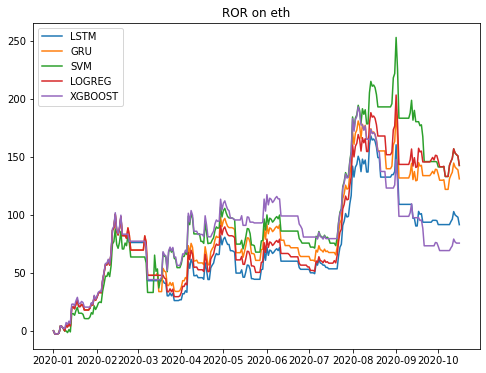

In [ ]:
visualize_ror(df_dict, 'eth')

In [ ]:
visualize_ror(df_dict, 'eth',is_purged=True)

In [ ]:
visualize_dd(df_dict, 'eth')

In [ ]:
visualize_dd(df_dict, 'eth',is_purged=True)

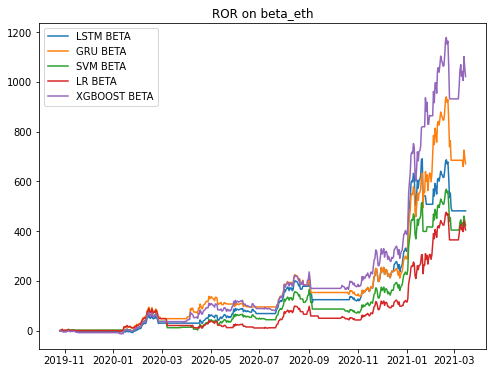

In [ ]:
visualize_ror(df_dict, 'eth_beta', is_beta = True)

In [ ]:
visualize_ror(df_dict, 'eth_beta', is_beta = True, is_purged = True)

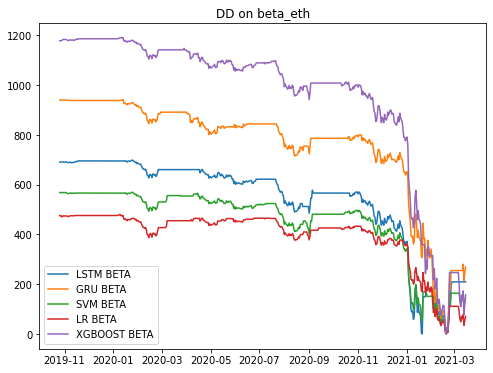

In [ ]:
visualize_dd(df_dict, 'eth_beta', is_beta = True)

In [ ]:
visualize_dd(df_dict, 'eth_beta', is_beta = True, is_purged = True)